In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import copy
from datetime import datetime, timedelta
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import brier_score_loss
from sklearn.metrics import make_scorer
from sklearn.utils.class_weight import compute_class_weight
import sys
import os
import joblib
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
import glob 


from sklearn import datasets, ensemble
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.utils import class_weight
import json

import xgboost as xgb
from bayes_opt import BayesianOptimization
import shap
import string
from multiprocessing import Pool


/glade/work/jhayron/conda-envs/pytorch_wr/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def generate_random_forecast(df_week_0, seed_value=42):
    # Set the random seed for reproducibility
    np.random.seed(seed_value)
    
    # Step 1: Get unique classes and their frequencies
    values = df_week_0[df_week_0.keys()[0]].value_counts()
    
    # Step 2: Calculate the probabilities for each class
    classes = values.index  # Unique classes
    probabilities = values / values.sum()  # Normalize to get probability distribution
    
    # Step 3: Generate a random forecast based on the probabilities
    random_forecast = np.random.choice(classes, size=len(df_week_0), p=probabilities)
    
    # Step 4: Return the random forecast as a DataFrame or Series
    forecast_df = pd.DataFrame(random_forecast, index=df_week_0.index, columns=['y_predicted'])
    
    return forecast_df

def generate_random_forecast_probabilities(df_week_0, seed_value=42):
    # Set the random seed for reproducibility
    np.random.seed(seed_value)
    # Step 1: Get unique classes and their frequencies
    values = df_week_0[df_week_0.keys()[0]].value_counts()
    
    # Step 2: Calculate the probabilities for each class
    classes = values.index  # Unique classes
    probabilities = values / values.sum()  # Normalize to get probability distribution
    
    # Step 3: Create a probability forecast for each sample
    # Create a 2D array where each row is the same probability distribution
    prob_matrix = np.tile(probabilities.values, (len(df_week_0), 1))
    
    # Step 4: Return the probability matrix as a DataFrame
    forecast_df = pd.DataFrame(prob_matrix, index=df_week_0.index, columns=classes)[np.arange(len(classes))]
    
    return forecast_df

def generate_random_forecast_with_monthly_probabilities(df_week_0, seed_value=42):
    # Set the random seed for reproducibility
    np.random.seed(seed_value)
    
    # Extract the month from the index (assuming the index is a datetime index)
    df_week_0['month'] = df_week_0.index.month
    
    # Prepare an empty list to store the random forecast
    forecasts = []
    
    # Loop through each month
    for month in range(1, 13):  # Loop through months 1 to 12
        # Filter data for the current month
        month_data = df_week_0[df_week_0['month'] == month]
        
        # Step 1: Get unique classes and their frequencies for the current month
        values = month_data[df_week_0.keys()[0]].value_counts()
        
        # Step 2: Calculate the probabilities for each class in the current month
        classes = values.index  # Unique classes
        probabilities = values / values.sum()  # Normalize to get probability distribution
        
        # Step 3: Generate random forecasts for the current month based on the probabilities
        month_forecast = np.random.choice(classes, size=len(month_data), p=probabilities)
        
        # Store the forecast for the current month
        forecasts.append(pd.Series(month_forecast, index=month_data.index))
    
    # Combine all monthly forecasts into one DataFrame
    forecast_df = pd.concat(forecasts)
    forecast_df = forecast_df.sort_index()  # Sort the index to preserve the original order
    forecast_df = pd.DataFrame(forecast_df,columns=['y_predicted'])
    return forecast_df
    
def generate_probability_forecast_with_monthly_probabilities(df_week_0, seed_value=42):
    # Set the random seed for reproducibility
    np.random.seed(seed_value)
    
    # Extract the month from the index (assuming the index is a datetime index)
    df_week_0['month'] = df_week_0.index.month
    
    # Prepare an empty DataFrame to store the probability forecasts
    all_probabilities = pd.DataFrame(index=df_week_0.index)
    
    # Loop through each month
    for month in range(1, 13):  # Loop through months 1 to 12
        # Filter data for the current month
        month_data = df_week_0[df_week_0['month'] == month]
        
        if month_data.empty:
            continue  # Skip if there's no data for the month
        
        # Step 1: Get unique classes and their frequencies for the current month
        values = month_data[df_week_0.keys()[0]].value_counts()
        
        # Step 2: Calculate the probabilities for each class in the current month
        classes = values.index  # Unique classes
        probabilities = values / values.sum()  # Normalize to get probability distribution
        
        # Step 3: Create a probability matrix for the current month
        prob_matrix = np.tile(probabilities.values, (len(month_data), 1))
        
        # Create a DataFrame for this month's probabilities with appropriate columns
        month_prob_df = pd.DataFrame(prob_matrix, index=month_data.index, columns=classes)
        
        # Append this month's DataFrame to the overall probability DataFrame
        all_probabilities = pd.concat([all_probabilities, month_prob_df])
    
    # Sort the index to match the original order
    all_probabilities = all_probabilities.sort_index()
    
    # Fill missing columns with zeros for months that do not include certain classes
    all_classes = df_week_0[df_week_0.keys()[0]].unique()
    all_probabilities = all_probabilities.reindex(columns=all_classes, fill_value=0).dropna()[np.arange(len(classes))]
    
    return all_probabilities

In [3]:
wr_original_series = pd.read_csv('/glade/work/jhayron/Data4Predictability/WR_Series_v20241226.csv',\
                index_col=0,names=['week0','dist'],skiprows=1,parse_dates=True)
# Rolling window for mode
rolling_mode = (
    wr_original_series.rolling('7d', center=True,min_periods=7)
    .apply(lambda x: x.mode()[0] if not x.mode().empty else float('nan'))
).shift(-3)

# Rolling window for the count of the mode
rolling_mode_count = (
    wr_original_series.rolling('7d', center=True,min_periods=7)
    .apply(lambda x: (x == x.mode()[0]).sum() if not x.mode().empty else 0)
).shift(-3)

# If duration of WR during week was less than 4, assing NO WR class
rolling_mode.loc[rolling_mode_count['week0']<4,'week0'] = 4
wr_series_mode = copy.deepcopy(rolling_mode)
time_index = pd.to_datetime(wr_series_mode.index).dayofweek
wr_series_mode = wr_series_mode.iloc[time_index.isin([0,3])].dropna()
wr_series = copy.deepcopy(wr_series_mode)

for wk in range(2,10):
    series_temp = copy.deepcopy(wr_series["week0"])
    series_temp.index = series_temp.index - timedelta(weeks = wk-1)
    series_temp.name = f'week{wk-1}'
    if wk==2:
        df_shifts = pd.concat([pd.DataFrame(wr_series["week0"]),pd.DataFrame(series_temp)],axis=1)  
    else:
        df_shifts = pd.concat([df_shifts,pd.DataFrame(series_temp)],axis=1)

In [4]:
list_files_anoms = np.sort(glob.glob('/glade/derecho/scratch/jhayron/Data4Predictability/WeeklyAnoms_DetrendedStd_v3_2dg/*.nc'))
list_vars = [list_files_anoms[i].split('/')[-1][:-3] for i in range(len(list_files_anoms))]

for ivar,var in enumerate(list_vars):
    print(ivar,var)

0 IC_SODA
1 IT_SODA
2 MLD_SODA
3 OHC100_SODA
4 OHC200_SODA
5 OHC300_SODA
6 OHC50_SODA
7 OHC700_SODA
8 OLR_ERA5
9 SD_ERA5
10 SSH_SODA
11 SST_OISSTv2
12 SST_SODA
13 STL_1m_ERA5
14 STL_28cm_ERA5
15 STL_7cm_ERA5
16 STL_full_ERA5
17 SWVL_1m_ERA5
18 SWVL_28cm_ERA5
19 SWVL_7cm_ERA5
20 SWVL_full_ERA5
21 U10_ERA5
22 U200_ERA5
23 Z500_ERA5


In [5]:
indices_vars_atm = [8,21,22,23]
indices_vars_ocn = [0,1,2,3,4,5,6,7,10,12]
indices_vars_lnd = [9,13,14,15,16,17,18,19,20]

In [6]:
all_indices  = np.concatenate([indices_vars_atm,indices_vars_ocn,indices_vars_lnd])

In [7]:
path_results = '/glade/derecho/scratch/jhayron/Data4Predictability/ResultsXGBoost/Results_v20241226/'

In [8]:
def compute_f1_for_sample(args):
    """Helper function to compute the F1 score for a sampled dataset."""
    results_temp, sample_indices = args
    sampled_data = results_temp.loc[sample_indices]
    return f1_score(sampled_data['y_true'], sampled_data['y_predicted'], average='micro')

def compute_f1_and_range(results_temp):
    metric_iterations = []
    num_iterations = 1000  # Adjust the number of iterations as needed

    # Generate the sample indices for bootstrapping
    sample_indices_list = [
        np.random.choice(results_temp.index, size=int(len(results_temp)), replace=True)
        for _ in range(num_iterations)
    ]

    # Use multiprocessing to compute F1 scores in parallel
    with Pool(processes=250) as pool:
        metric_iterations = pool.map(compute_f1_for_sample, [(results_temp, sample_indices) for sample_indices in sample_indices_list])

    # Compute the mean and percentiles
    metric_mean = f1_score(results_temp['y_true'], results_temp['y_predicted'], average='micro')
    metric_95th = np.percentile(metric_iterations, 95)
    metric_5th = np.percentile(metric_iterations, 5)

    return metric_mean, metric_95th, metric_5th

In [18]:
path_f1s = '/glade/derecho/scratch/jhayron/Data4Predictability/ResultsXGBoost/F1s_v20241226/f1s_5Classes/'

In [19]:
for ivar in all_indices:
    print(list_vars[ivar])
    
    path_weekly_anoms = '/glade/derecho/scratch/jhayron/Data4Predictability/WeeklyAnoms_DetrendedStd_v3_2dg/'

    results_weeks = {}
    results_probs_weeks = {}
    
    for week_out in range(1,9):
        print(f'WEEK: {week_out}')
        week_out_str = f'week{week_out}'
        df_results_full = pd.read_csv(f'{path_results}Results_{list_vars[ivar]}_{week_out_str}.csv',
                                     index_col=0, parse_dates=True)
        results_weeks[week_out_str] = df_results_full
        print(np.bincount(results_weeks[week_out_str]['y_true'])/len(results_weeks[week_out_str]))
        print(np.bincount(results_weeks[week_out_str]['y_predicted'])/len(results_weeks[week_out_str]))
    f1_xgb = []
    if ivar==8:
        f1_persistence = []
        f1_climatology = []
        f1_random = []
    
    for week_out in range(1,9):
        # week_out = 5
        week_out_str = f'week{week_out}'
        df_week_forecast = df_shifts[[week_out_str]].dropna()
        random_forecast = generate_random_forecast(df_week_forecast, seed_value=42)    
        climatology_forecast = generate_random_forecast_with_monthly_probabilities(df_week_forecast, seed_value=42)

        df_results_temp = results_weeks[week_out_str]
        
        df_results_temp_persistence = copy.deepcopy(df_results_temp)
        df_week_0 = df_shifts[['week0']].dropna()
        df_results_temp_persistence['y_predicted'] = df_week_0.loc[df_results_temp['y_true'].index].values
        
        df_results_temp_random = copy.deepcopy(df_results_temp)
        df_results_temp_random['y_predicted'] = random_forecast.loc[df_results_temp['y_true'].index].values
        
        df_results_temp_clima = copy.deepcopy(df_results_temp)
        df_results_temp_clima['y_predicted'] = climatology_forecast.loc[df_results_temp['y_true'].index].values
        
        f1_xgb.append(compute_f1_and_range(df_results_temp))
        if ivar==8:
            f1_persistence.append(compute_f1_and_range(df_results_temp_persistence))
            f1_climatology.append(compute_f1_and_range(df_results_temp_clima))
            f1_random.append(compute_f1_and_range(df_results_temp_random))
    
    f1_xgb = np.array(f1_xgb)
    if ivar==8:
        f1_persistence = np.array(f1_persistence)
        f1_climatology = np.array(f1_climatology)
        f1_random = np.array(f1_random)
        np.save(f'{path_f1s}/f1_persistence.npy',f1_persistence)
        np.save(f'{path_f1s}/f1_climatology.npy',f1_climatology)
        np.save(f'{path_f1s}/f1_random.npy',f1_random)

    np.save(f'{path_f1s}/f1_{list_vars[ivar]}.npy',f1_xgb)

OLR_ERA5
WEEK: 1
[0.23535062 0.20509126 0.1623439  0.11959654 0.27761768]
[0.27089337 0.20677233 0.14649376 0.10230548 0.27353506]
WEEK: 2
[0.23487032 0.20509126 0.1623439  0.11959654 0.27809798]
[0.23511047 0.21709894 0.13736792 0.05955812 0.35086455]
WEEK: 3
[0.23439001 0.20557157 0.1623439  0.11959654 0.27809798]
[0.25600384 0.19932757 0.09197887 0.04586936 0.40682037]
WEEK: 4
[0.23439001 0.20557157 0.1623439  0.11959654 0.27809798]
[0.25048031 0.21085495 0.13592699 0.05451489 0.34822286]
WEEK: 5
[0.23450264 0.20567035 0.16242191 0.11941374 0.27799135]
[0.24243152 0.22969726 0.11725132 0.06823642 0.34238347]
WEEK: 6
[0.234375   0.20576923 0.1625     0.11923077 0.278125  ]
[0.22620192 0.24134615 0.12692308 0.05889423 0.34663462]
WEEK: 7
[0.23424723 0.20586821 0.16257816 0.11928812 0.27801828]
[0.26070226 0.18686869 0.14045214 0.07239057 0.33958634]
WEEK: 8
[0.23435996 0.20596728 0.16241578 0.11934552 0.27791145]
[0.27358037 0.21246391 0.12295476 0.05774783 0.33325313]
U10_ERA5
WEEK: 

In [20]:
for component in ['atm','ocn','lnd','all']:
    print(component)
    
    path_weekly_anoms = '/glade/derecho/scratch/jhayron/Data4Predictability/WeeklyAnoms_DetrendedStd_v3_2dg/'

    results_weeks = {}
    results_probs_weeks = {}
    
    for week_out in range(1,9):
        # print(f'WEEK: {week_out}')
        week_out_str = f'week{week_out}'
        df_results_full = pd.read_csv(f'{path_results}Results_{component}_{week_out_str}.csv',
                                     index_col=0, parse_dates=True)

        results_weeks[week_out_str] = df_results_full

    f1_xgb = []

    for week_out in range(1,9):
        # week_out = 5
        week_out_str = f'week{week_out}'
        df_week_forecast = df_shifts[[week_out_str]].dropna()
        random_forecast = generate_random_forecast(df_week_forecast, seed_value=42)    
        climatology_forecast = generate_random_forecast_with_monthly_probabilities(df_week_forecast, seed_value=42)
        
        df_results_temp = results_weeks[week_out_str]
        
        df_results_temp_persistence = copy.deepcopy(df_results_temp)
        df_week_0 = df_shifts[['week0']].dropna()
        df_results_temp_persistence['y_predicted'] = df_week_0.loc[df_results_temp['y_true'].index].values
        
        df_results_temp_random = copy.deepcopy(df_results_temp)
        df_results_temp_random['y_predicted'] = random_forecast.loc[df_results_temp['y_true'].index].values
        
        df_results_temp_clima = copy.deepcopy(df_results_temp)
        df_results_temp_clima['y_predicted'] = climatology_forecast.loc[df_results_temp['y_true'].index].values
        
        f1_xgb.append(compute_f1_and_range(df_results_temp))
    
    f1_xgb = np.array(f1_xgb)
    np.save(f'{path_f1s}/f1_{component}.npy',f1_xgb)

atm
ocn
lnd
all


In [21]:
dic_atm = {}
dic_atm['all_f1s'] = []
dic_atm['names'] = []

for ivar in indices_vars_atm:
    dic_atm['all_f1s'].append(np.load(f'{path_f1s}/f1_{list_vars[ivar]}.npy'))
    dic_atm['names'].append(list_vars[ivar])
dic_atm['all_f1s'].append(np.load(f'{path_f1s}/f1_atm.npy'))
dic_atm['names'].append(f'All atm.')

dic_atm['all_f1s'] = np.array(dic_atm['all_f1s'])
dic_atm['names'] = np.array(dic_atm['names'])
dic_atm['best_model'] = dic_atm['names'][dic_atm['all_f1s'][:,:,0].argmax(axis=0)]

dic_ocn = {}
dic_ocn['all_f1s'] = []
dic_ocn['names'] = []

for ivar in indices_vars_ocn:
    dic_ocn['all_f1s'].append(np.load(f'{path_f1s}/f1_{list_vars[ivar]}.npy'))
    dic_ocn['names'].append(list_vars[ivar])
dic_ocn['all_f1s'].append(np.load(f'{path_f1s}/f1_ocn.npy'))
dic_ocn['names'].append(f'All ocn.')

dic_ocn['all_f1s'] = np.array(dic_ocn['all_f1s'])
dic_ocn['names'] = np.array(dic_ocn['names'])
dic_ocn['best_model'] = dic_ocn['names'][dic_ocn['all_f1s'][:,:,0].argmax(axis=0)]

dic_lnd = {}
dic_lnd['all_f1s'] = []
dic_lnd['names'] = []

for ivar in indices_vars_lnd:
    dic_lnd['all_f1s'].append(np.load(f'{path_f1s}/f1_{list_vars[ivar]}.npy'))
    dic_lnd['names'].append(list_vars[ivar])
dic_lnd['all_f1s'].append(np.load(f'{path_f1s}/f1_lnd.npy'))
dic_lnd['names'].append(f'All lnd.')

dic_lnd['all_f1s'] = np.array(dic_lnd['all_f1s'])
dic_lnd['names'] = np.array(dic_lnd['names'])
dic_lnd['best_model'] = dic_lnd['names'][dic_lnd['all_f1s'][:,:,0].argmax(axis=0)]

f1_persistence = np.load(f'{path_f1s}/f1_persistence.npy')
f1_climatology = np.load(f'{path_f1s}/f1_climatology.npy')
f1_random = np.load(f'{path_f1s}/f1_random.npy')
weeks = np.arange(1,9)

In [22]:
f1_all_all = np.load(f'{path_f1s}/f1_all.npy')

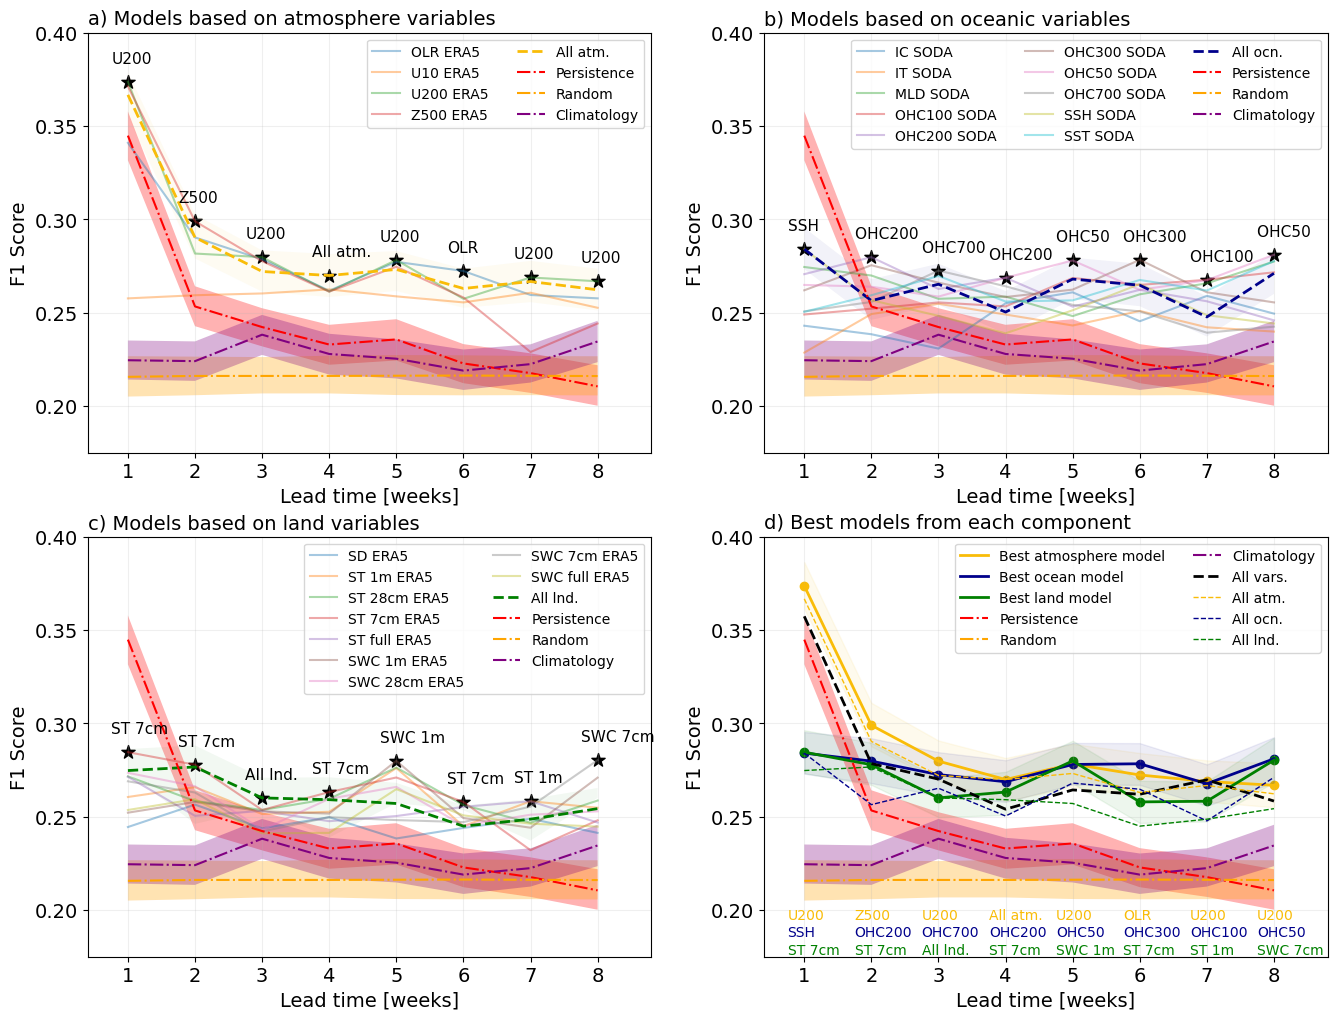

In [23]:
# Create a figure and a set of subplots
fig, axs = plt.subplots(2, 2,figsize=(16,12))  # 2x2 grid of subplots
upper_ylim = 0.4
lower_ylim = 0.175
##### ATMOSPHERE ####

for acc_temp, name_temp in zip(dic_atm['all_f1s'][:,:,0], dic_atm['names']):
    if name_temp == 'All atm.':
        axs[0,0].plot(weeks, np.array(acc_temp)[:], 
                label=(name_temp.replace('_',' ').replace('SWVL','SWC').replace('STL','ST')), 
                alpha=1,color='#f9bc08',lw=2,ls='dashed')
    else:
        axs[0,0].plot(weeks, np.array(acc_temp)[:], 
                label=(name_temp.replace('_',' ').replace('SWVL','SWC').replace('STL','ST')), 
                alpha=0.4)
axs[0,0].fill_between(weeks, dic_atm['all_f1s'][-1,:,1],dic_atm['all_f1s'][-1,:,2], 
                      color='#f9bc08', ls='dashdot', lw=0.01,alpha=0.05)

# Plot best model
for i, j, d in zip(weeks, np.max(np.array(dic_atm['all_f1s'][:,:,0]), axis=0), dic_atm['best_model'][:]):
    axs[0,0].scatter(i, j, color='k', marker='*', s=100)
    axs[0,0].text(i - 0.25, j + 0.01, s=d.replace('SWVL','SWC').replace('STL','ST').replace('_ERA5',''),fontsize=11)

# Plot benchmarks
axs[0,0].plot(weeks, f1_persistence[:,0], color='red', label='Persistence', ls='dashdot')
axs[0,0].fill_between(weeks, f1_persistence[:,1],f1_persistence[:,2], 
                      color='red', ls='dashdot', lw=0.01,alpha=0.3)


axs[0,0].plot(weeks, f1_random[:,0], color='orange', label='Random', ls='dashdot')
axs[0,0].fill_between(weeks, f1_random[:,1],f1_random[:,2], 
                      color='orange', ls='dashdot', lw=0.01,alpha=0.3)

axs[0,0].plot(weeks, f1_climatology[:,0], color='purple', label='Climatology', ls='dashdot')
axs[0,0].fill_between(weeks, f1_climatology[:,1],f1_climatology[:,2], 
                      color='purple', ls='dashdot', lw=0.01,alpha=0.3)

# Finalizing plot
axs[0,0].set_ylim(lower_ylim, upper_ylim)
axs[0,0].set_xlim(0.4, 8.8)
axs[0,0].tick_params(axis='both', which='major', labelsize=14)
axs[0,0].grid(alpha=0.2)
axs[0,0].set_ylabel('F1 Score',fontsize=14)
axs[0,0].set_xlabel('Lead time [weeks]',fontsize=14)
axs[0,0].set_title(f'a) Models based on atmosphere variables', loc='left',fontsize=14)
axs[0,0].legend(bbox_to_anchor=(1, 1.0), fontsize=10, ncol=2)


##### OCEAN ####

for acc_temp, name_temp in zip(dic_ocn['all_f1s'][:,:,0], dic_ocn['names']):
    if name_temp == 'All ocn.':
        axs[0,1].plot(weeks, np.array(acc_temp)[:], 
                label=(name_temp.replace('_',' ').replace('SWVL','SWC').replace('STL','ST')), 
                alpha=1,color='darkblue',lw=2,ls='dashed')
    else:
        axs[0,1].plot(weeks, np.array(acc_temp)[:], 
                label=(name_temp.replace('_',' ').replace('SWVL','SWC').replace('STL','ST')), 
                alpha=0.4)
axs[0,1].fill_between(weeks, dic_ocn['all_f1s'][-1,:,1],dic_ocn['all_f1s'][-1,:,2], 
                      color='darkblue', ls='dashdot', lw=0.01,alpha=0.05)
# Plot best model
for i, j, d in zip(weeks, np.max(np.array(dic_ocn['all_f1s'][:,:,0]), axis=0), dic_ocn['best_model'][:]):
    axs[0,1].scatter(i, j, color='k', marker='*', s=100)
    axs[0,1].text(i - 0.25, j + 0.01, s=d.replace('SWVL','SWC').replace('STL','ST')\
                  .replace('SODA','').replace('_',' ').replace(' OISS','\nOISS').replace(' wT','\nwT'),
                  fontsize=11)

# Plot benchmarks
axs[0,1].plot(weeks, f1_persistence[:,0], color='red', label='Persistence', ls='dashdot')
axs[0,1].fill_between(weeks, f1_persistence[:,1],f1_persistence[:,2], 
                      color='red', ls='dashdot', lw=0.01,alpha=0.3)


axs[0,1].plot(weeks, f1_random[:,0], color='orange', label='Random', ls='dashdot')
axs[0,1].fill_between(weeks, f1_random[:,1],f1_random[:,2], 
                      color='orange', ls='dashdot', lw=0.01,alpha=0.3)

axs[0,1].plot(weeks, f1_climatology[:,0], color='purple', label='Climatology', ls='dashdot')
axs[0,1].fill_between(weeks, f1_climatology[:,1],f1_climatology[:,2], 
                      color='purple', ls='dashdot', lw=0.01,alpha=0.3)

# Finalizing plot
axs[0,1].set_ylim(lower_ylim, upper_ylim)
axs[0,1].set_xlim(0.4, 8.8)
axs[0,1].tick_params(axis='both', which='major', labelsize=14)
axs[0,1].grid(alpha=0.2)
axs[0,1].set_ylabel('F1 Score',fontsize=14)
axs[0,1].set_xlabel('Lead time [weeks]',fontsize=14)
axs[0,1].set_title(f'b) Models based on oceanic variables', loc='left',fontsize=14)
axs[0,1].legend(bbox_to_anchor=(1, 1.0), fontsize=10, ncol=3)

##### LAND ####

for acc_temp, name_temp in zip(dic_lnd['all_f1s'][:,:,0], dic_lnd['names']):
    if name_temp == 'All lnd.':
        axs[1,0].plot(weeks, np.array(acc_temp)[:], 
                label=(name_temp.replace('_',' ').replace('SWVL','SWC').replace('STL','ST')), 
                alpha=1,color='green',lw=2,ls='dashed')
    else:
        axs[1,0].plot(weeks, np.array(acc_temp)[:], 
                label=(name_temp.replace('_',' ').replace('SWVL','SWC').replace('STL','ST')), 
                alpha=0.4)
axs[1,0].fill_between(weeks, dic_lnd['all_f1s'][-1,:,1],dic_ocn['all_f1s'][-1,:,2], 
                      color='green', ls='dashdot', lw=0.01,alpha=0.05)
# Plot best model
for i, j, d in zip(weeks, np.max(np.array(dic_lnd['all_f1s'][:,:,0]), axis=0), dic_lnd['best_model'][:]):
    axs[1,0].scatter(i, j, color='k', marker='*', s=100)
    axs[1,0].text(i - 0.25, j + 0.01, s=d.replace('SWVL','SWC').replace('STL','ST')\
                  .replace('ERA5','').replace('_',' ').replace(' wT','\nwT'),fontsize=11)

# Plot benchmarks
axs[1,0].plot(weeks, f1_persistence[:,0], color='red', label='Persistence', ls='dashdot')
axs[1,0].fill_between(weeks, f1_persistence[:,1],f1_persistence[:,2], 
                      color='red', ls='dashdot', lw=0.01,alpha=0.3)


axs[1,0].plot(weeks, f1_random[:,0], color='orange', label='Random', ls='dashdot')
axs[1,0].fill_between(weeks, f1_random[:,1],f1_random[:,2], 
                      color='orange', ls='dashdot', lw=0.01,alpha=0.3)

axs[1,0].plot(weeks, f1_climatology[:,0], color='purple', label='Climatology', ls='dashdot')
axs[1,0].fill_between(weeks, f1_climatology[:,1],f1_climatology[:,2], 
                      color='purple', ls='dashdot', lw=0.01,alpha=0.3)

# Finalizing plot
axs[1,0].set_ylim(lower_ylim, upper_ylim)
axs[1,0].set_xlim(0.4, 8.8)
axs[1,0].tick_params(axis='both', which='major', labelsize=14)
axs[1,0].grid(alpha=0.2)
axs[1,0].set_ylabel('F1 Score',fontsize=14)
axs[1,0].set_xlabel('Lead time [weeks]',fontsize=14)
axs[1,0].set_title(f'c) Models based on land variables', loc='left',fontsize=14)
axs[1,0].legend(bbox_to_anchor=(1, 1.0), fontsize=10, ncol=2)


#### BEST MODEL ALL COMPONENTS #####

best_f1_atm = np.array([dic_atm['all_f1s'][iwhere, iweek]\
                    for iweek, iwhere in enumerate(dic_atm['all_f1s'][:,:,0].argmax(axis=0))])

best_f1_ocn = np.array([dic_ocn['all_f1s'][iwhere, iweek]\
                    for iweek, iwhere in enumerate(dic_ocn['all_f1s'][:,:,0].argmax(axis=0))])

best_f1_lnd = np.array([dic_lnd['all_f1s'][iwhere, iweek]\
                    for iweek, iwhere in enumerate(dic_lnd['all_f1s'][:,:,0].argmax(axis=0))])

axs[1,1].plot(weeks,best_f1_atm[:,0],label=f'Best atmosphere model',color='#f9bc08',lw=2)
axs[1,1].scatter(weeks,best_f1_atm[:,0],color='#f9bc08')#, s=diff*100)

axs[1,1].plot(weeks,best_f1_ocn[:,0],label=f'Best ocean model',color='darkblue',lw=2)
axs[1,1].scatter(weeks,best_f1_ocn[:,0],color='darkblue')

axs[1,1].plot(weeks,best_f1_lnd[:,0],label=f'Best land model',color='green',lw=2)
axs[1,1].scatter(weeks,best_f1_lnd[:,0],color='green')

axs[1,1].fill_between(weeks, best_f1_atm[:,1], 
                 best_f1_atm[:,2], color='#f9bc08', alpha=0.07)
axs[1,1].fill_between(weeks, best_f1_ocn[:,1], 
                 best_f1_ocn[:,2], color='darkblue', alpha=0.07)
axs[1,1].fill_between(weeks, best_f1_lnd[:,1], 
                 best_f1_lnd[:,2], color='green', alpha=0.07)

# Plot benchmarks
axs[1,1].plot(weeks, f1_persistence[:,0], color='red', label='Persistence', ls='dashdot')
axs[1,1].fill_between(weeks, f1_persistence[:,1],f1_persistence[:,2], 
                      color='red', ls='dashdot', lw=0.01,alpha=0.3)


axs[1,1].plot(weeks, f1_random[:,0], color='orange', label='Random', ls='dashdot')
axs[1,1].fill_between(weeks, f1_random[:,1],f1_random[:,2], 
                      color='orange', ls='dashdot', lw=0.01,alpha=0.3)

axs[1,1].plot(weeks, f1_climatology[:,0], color='purple', label='Climatology', ls='dashdot')
axs[1,1].fill_between(weeks, f1_climatology[:,1],f1_climatology[:,2], 
                      color='purple', ls='dashdot', lw=0.01,alpha=0.3)

# Plot best model
for i, j, d in zip(weeks, best_f1_atm[:,0], dic_atm['best_model'][:]):
    axs[1,1].text(i - 0.25, 0.195-0.0, s=d.replace('_ERA5',''), 
                  color = '#f9bc08',fontsize=10)
for i, j, d in zip(weeks, best_f1_ocn[:,0], dic_ocn['best_model'][:]):
    axs[1,1].text(i - 0.25, 0.186-0.0, s=d.replace('_SODA','').replace('_OISSTv2','')\
                  .replace('_wT',' \nwT'), 
                  color = 'darkblue',fontsize=10)
for i, j, d in zip(weeks, best_f1_lnd[:,0], dic_lnd['best_model'][:]):
    axs[1,1].text(i - 0.25,  0.176-0.0, s=d.replace('SWVL','SWC').replace('STL','ST')\
                  .replace('_ERA5','').replace('_',' ').replace(' wT',' \nwT'), 
                  color = 'green',fontsize=10)

axs[1,1].plot(weeks, f1_all_all[:,0], color='k', label='All vars.', ls='dashed', lw=2)
axs[1,1].plot(weeks, dic_atm['all_f1s'][-1,:,0], color='#f9bc08', label='All atm.', ls='dashed', lw=1)
axs[1,1].plot(weeks, dic_ocn['all_f1s'][-1,:,0], color='darkblue', label='All ocn.', ls='dashed', lw=1)
axs[1,1].plot(weeks, dic_lnd['all_f1s'][-1,:,0], color='green', label='All lnd.', ls='dashed', lw=1)
# axs[1,1].fill_between(weeks, f1_all_all[:,1],f1_all_all[:,2], 
#                       color='blue', ls='dashdot', lw=0.01,alpha=0.05)

axs[1,1].set_xlim(0.4, 8.8)
axs[1,1].set_ylim(lower_ylim, upper_ylim)
axs[1,1].tick_params(axis='both', which='major', labelsize=14)
axs[1,1].grid(alpha=0.2)
axs[1,1].set_ylabel('F1 Score',fontsize=14)
axs[1,1].set_xlabel('Lead time [weeks]',fontsize=14)
axs[1,1].set_title(f'd) Best models from each component', loc='left',fontsize=14)
axs[1,1].legend(bbox_to_anchor=(1, 1.0), fontsize=10,ncol=2)
# plt.savefig('Figures/2_f1Components.png',bbox_inches='tight')

# Seasonal plots

In [24]:
path_results_seasonal = '/glade/derecho/scratch/jhayron/Data4Predictability/ResultsXGBoost/F1s_v20241226/f1s_seasonal/'

In [12]:
indices_seasons = {'Winter':[12,1,2],
                   'Spring':[3,4,5],
                   'Summer':[6,7,8],
                   'Fall':[9,10,11]}

In [26]:
for iseason, season in enumerate(indices_seasons.keys()):
    for ivar in all_indices:
        print(list_vars[ivar])
        results_weeks = {}
        results_probs_weeks = {}
        
        for week_out in range(1,9):
            # print(f'WEEK: {week_out}')
            week_out_str = f'week{week_out}'
            df_results_full = pd.read_csv(f'{path_results}Results_{list_vars[ivar]}_{week_out_str}.csv',
                                         index_col=0, parse_dates=True)

            #### Filter by season ####
            df_results_full = df_results_full.loc[(df_results_full.index.month==indices_seasons[season][0])|\
                            (df_results_full.index.month==indices_seasons[season][1])|\
                            (df_results_full.index.month==indices_seasons[season][2])]
            ##########################
            results_weeks[week_out_str] = df_results_full
    
        f1_xgb = []
        if ivar==8:
            f1_persistence = []
            f1_climatology = []
            f1_random = []
        
        for week_out in range(1,9):
            # week_out = 5
            week_out_str = f'week{week_out}'
            df_week_forecast = df_shifts[[week_out_str]].dropna()
            random_forecast = generate_random_forecast(df_week_forecast, seed_value=42)    
            climatology_forecast = generate_random_forecast_with_monthly_probabilities(df_week_forecast, seed_value=42)
            
            df_results_temp = results_weeks[week_out_str]
            
            df_results_temp_persistence = copy.deepcopy(df_results_temp)
            df_week_0 = df_shifts[['week0']].dropna()
            df_results_temp_persistence['y_predicted'] = df_week_0.loc[df_results_temp['y_true'].index].values
            
            df_results_temp_random = copy.deepcopy(df_results_temp)
            df_results_temp_random['y_predicted'] = random_forecast.loc[df_results_temp['y_true'].index].values
            
            df_results_temp_clima = copy.deepcopy(df_results_temp)
            df_results_temp_clima['y_predicted'] = climatology_forecast.loc[df_results_temp['y_true'].index].values
            
            f1_xgb.append(compute_f1_and_range(df_results_temp))
            if ivar==8:
                f1_persistence.append(compute_f1_and_range(df_results_temp_persistence))
                f1_climatology.append(compute_f1_and_range(df_results_temp_clima))
                f1_random.append(compute_f1_and_range(df_results_temp_random))
        
        f1_xgb = np.array(f1_xgb)
        if ivar==8:
            f1_persistence = np.array(f1_persistence)
            f1_climatology = np.array(f1_climatology)
            f1_random = np.array(f1_random)
            np.save(f'{path_results_seasonal}/f1_persistence_{season}.npy',f1_persistence)
            np.save(f'{path_results_seasonal}/f1_climatology_{season}.npy',f1_climatology)
            np.save(f'{path_results_seasonal}/f1_random_{season}.npy',f1_random)
    
        np.save(f'{path_results_seasonal}/f1_{list_vars[ivar]}_{season}.npy',f1_xgb)
        

OLR_ERA5
U10_ERA5
U200_ERA5
Z500_ERA5
IC_SODA
IT_SODA
MLD_SODA
OHC100_SODA
OHC200_SODA
OHC300_SODA
OHC50_SODA
OHC700_SODA
SSH_SODA
SST_SODA
SD_ERA5
STL_1m_ERA5
STL_28cm_ERA5
STL_7cm_ERA5
STL_full_ERA5
SWVL_1m_ERA5
SWVL_28cm_ERA5
SWVL_7cm_ERA5
SWVL_full_ERA5
OLR_ERA5
U10_ERA5
U200_ERA5
Z500_ERA5
IC_SODA
IT_SODA
MLD_SODA
OHC100_SODA
OHC200_SODA
OHC300_SODA
OHC50_SODA
OHC700_SODA
SSH_SODA
SST_SODA
SD_ERA5
STL_1m_ERA5
STL_28cm_ERA5
STL_7cm_ERA5
STL_full_ERA5
SWVL_1m_ERA5
SWVL_28cm_ERA5
SWVL_7cm_ERA5
SWVL_full_ERA5
OLR_ERA5
U10_ERA5
U200_ERA5
Z500_ERA5
IC_SODA
IT_SODA
MLD_SODA
OHC100_SODA
OHC200_SODA
OHC300_SODA
OHC50_SODA
OHC700_SODA
SSH_SODA
SST_SODA
SD_ERA5
STL_1m_ERA5
STL_28cm_ERA5
STL_7cm_ERA5
STL_full_ERA5
SWVL_1m_ERA5
SWVL_28cm_ERA5
SWVL_7cm_ERA5
SWVL_full_ERA5
OLR_ERA5
U10_ERA5
U200_ERA5
Z500_ERA5
IC_SODA
IT_SODA
MLD_SODA
OHC100_SODA
OHC200_SODA
OHC300_SODA
OHC50_SODA
OHC700_SODA
SSH_SODA
SST_SODA
SD_ERA5
STL_1m_ERA5
STL_28cm_ERA5
STL_7cm_ERA5
STL_full_ERA5
SWVL_1m_ERA5
SWVL_28cm_ER

In [27]:
for iseason, season in enumerate(indices_seasons.keys()):
    for component in ['atm','ocn','lnd','all']:
        print(component)
        
        path_weekly_anoms = '/glade/derecho/scratch/jhayron/Data4Predictability/WeeklyAnoms_DetrendedStd_v3_2dg/'
    
        results_weeks = {}
        results_probs_weeks = {}
        
        for week_out in range(1,9):
            # print(f'WEEK: {week_out}')
            week_out_str = f'week{week_out}'
            df_results_full = pd.read_csv(f'{path_results}Results_{component}_{week_out_str}.csv',
                                         index_col=0, parse_dates=True)
            #### Filter by season ####
            df_results_full = df_results_full.loc[(df_results_full.index.month==indices_seasons[season][0])|\
                            (df_results_full.index.month==indices_seasons[season][1])|\
                            (df_results_full.index.month==indices_seasons[season][2])]
    
            results_weeks[week_out_str] = df_results_full
    
        f1_xgb = []
    
        for week_out in range(1,9):
            # week_out = 5
            week_out_str = f'week{week_out}'
            df_week_forecast = df_shifts[[week_out_str]].dropna()
            random_forecast = generate_random_forecast(df_week_forecast, seed_value=42)    
            climatology_forecast = generate_random_forecast_with_monthly_probabilities(df_week_forecast, seed_value=42)
            
            df_results_temp = results_weeks[week_out_str]
            
            df_results_temp_persistence = copy.deepcopy(df_results_temp)
            df_week_0 = df_shifts[['week0']].dropna()
            df_results_temp_persistence['y_predicted'] = df_week_0.loc[df_results_temp['y_true'].index].values
            
            df_results_temp_random = copy.deepcopy(df_results_temp)
            df_results_temp_random['y_predicted'] = random_forecast.loc[df_results_temp['y_true'].index].values
            
            df_results_temp_clima = copy.deepcopy(df_results_temp)
            df_results_temp_clima['y_predicted'] = climatology_forecast.loc[df_results_temp['y_true'].index].values
            
            f1_xgb.append(compute_f1_and_range(df_results_temp))
        
        f1_xgb = np.array(f1_xgb)
        np.save(f'{path_results_seasonal}/f1_{component}_{season}.npy',f1_xgb)

atm
ocn
lnd
all
atm
ocn
lnd
all
atm
ocn


In [28]:
path_f1s_seasonal = '/glade/derecho/scratch/jhayron/Data4Predictability/ResultsXGBoost/F1s_v20241226/f1s_seasonal/'

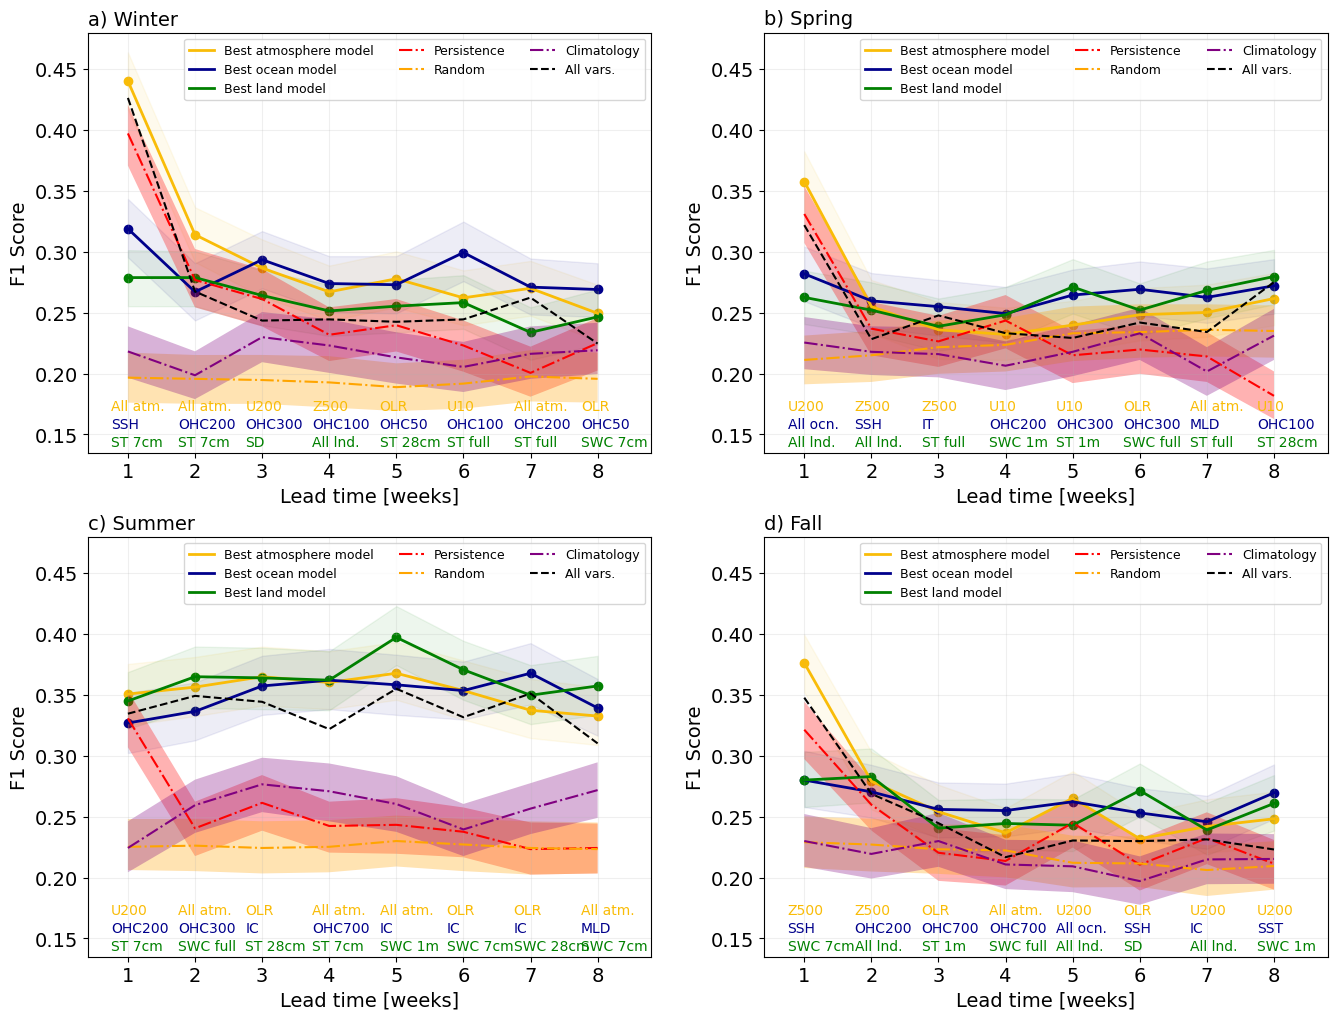

In [29]:
# Create a figure and a set of subplots
fig, axs = plt.subplots(2, 2,figsize=(16,12))  # 2x2 grid of subplots

# Flatten the axs array and convert to list
axs_list = axs.flatten().tolist()

for iseason, season in enumerate(indices_seasons.keys()):
    dic_atm = {}
    dic_atm['all_f1s'] = []
    dic_atm['names'] = []
    
    for ivar in indices_vars_atm:
        dic_atm['all_f1s'].append(np.load(f'{path_f1s_seasonal}/f1_{list_vars[ivar]}_{season}.npy'))
        dic_atm['names'].append(list_vars[ivar])
    dic_atm['all_f1s'].append(np.load(f'{path_f1s_seasonal}/f1_atm_{season}.npy'))
    dic_atm['names'].append(f'All atm.')
    
    dic_atm['all_f1s'] = np.array(dic_atm['all_f1s'])
    dic_atm['names'] = np.array(dic_atm['names'])
    dic_atm['best_model'] = dic_atm['names'][dic_atm['all_f1s'][:,:,0].argmax(axis=0)]
    
    dic_ocn = {}
    dic_ocn['all_f1s'] = []
    dic_ocn['names'] = []
    
    for ivar in indices_vars_ocn:
        dic_ocn['all_f1s'].append(np.load(f'{path_f1s_seasonal}/f1_{list_vars[ivar]}_{season}.npy'))
        dic_ocn['names'].append(list_vars[ivar])
    dic_ocn['all_f1s'].append(np.load(f'{path_f1s_seasonal}/f1_ocn_{season}.npy'))
    dic_ocn['names'].append(f'All ocn.')
    
    dic_ocn['all_f1s'] = np.array(dic_ocn['all_f1s'])
    dic_ocn['names'] = np.array(dic_ocn['names'])
    dic_ocn['best_model'] = dic_ocn['names'][dic_ocn['all_f1s'][:,:,0].argmax(axis=0)]
    
    dic_lnd = {}
    dic_lnd['all_f1s'] = []
    dic_lnd['names'] = []
    
    for ivar in indices_vars_lnd:
        dic_lnd['all_f1s'].append(np.load(f'{path_f1s_seasonal}/f1_{list_vars[ivar]}_{season}.npy'))
        dic_lnd['names'].append(list_vars[ivar])
    dic_lnd['all_f1s'].append(np.load(f'{path_f1s_seasonal}/f1_lnd_{season}.npy'))
    dic_lnd['names'].append(f'All lnd.')
    
    dic_lnd['all_f1s'] = np.array(dic_lnd['all_f1s'])
    dic_lnd['names'] = np.array(dic_lnd['names'])
    dic_lnd['best_model'] = dic_lnd['names'][dic_lnd['all_f1s'][:,:,0].argmax(axis=0)]
    
    f1_persistence = np.load(f'{path_f1s_seasonal}/f1_persistence_{season}.npy')
    f1_climatology = np.load(f'{path_f1s_seasonal}/f1_climatology_{season}.npy')
    f1_random = np.load(f'{path_f1s_seasonal}/f1_random_{season}.npy')
    f1_all = np.load(f'{path_f1s_seasonal}/f1_all_{season}.npy')

    weeks = np.arange(1,9)

    ##### PLOT

    best_f1_atm = np.array([dic_atm['all_f1s'][iwhere, iweek]\
                        for iweek, iwhere in enumerate(dic_atm['all_f1s'][:,:,0].argmax(axis=0))])
    
    best_f1_ocn = np.array([dic_ocn['all_f1s'][iwhere, iweek]\
                        for iweek, iwhere in enumerate(dic_ocn['all_f1s'][:,:,0].argmax(axis=0))])
    
    best_f1_lnd = np.array([dic_lnd['all_f1s'][iwhere, iweek]\
                        for iweek, iwhere in enumerate(dic_lnd['all_f1s'][:,:,0].argmax(axis=0))])
    
    axs_list[iseason].plot(weeks,best_f1_atm[:,0],label=f'Best atmosphere model',color='#f9bc08',lw=2)
    axs_list[iseason].scatter(weeks,best_f1_atm[:,0],color='#f9bc08')#, s=diff*100)
    
    axs_list[iseason].plot(weeks,best_f1_ocn[:,0],label=f'Best ocean model',color='darkblue',lw=2)
    axs_list[iseason].scatter(weeks,best_f1_ocn[:,0],color='darkblue')
    
    axs_list[iseason].plot(weeks,best_f1_lnd[:,0],label=f'Best land model',color='green',lw=2)
    axs_list[iseason].scatter(weeks,best_f1_lnd[:,0],color='green')
    
    axs_list[iseason].fill_between(weeks, best_f1_atm[:,1], 
                     best_f1_atm[:,2], color='#f9bc08', alpha=0.07)
    axs_list[iseason].fill_between(weeks, best_f1_ocn[:,1], 
                     best_f1_ocn[:,2], color='darkblue', alpha=0.07)
    axs_list[iseason].fill_between(weeks, best_f1_lnd[:,1], 
                     best_f1_lnd[:,2], color='green', alpha=0.07)
    
    # Plot benchmarks
    axs_list[iseason].plot(weeks, f1_persistence[:,0], color='red', label='Persistence', ls='dashdot')
    axs_list[iseason].fill_between(weeks, f1_persistence[:,1],f1_persistence[:,2], 
                          color='red', ls='dashdot', lw=0.01,alpha=0.3)
    
    
    axs_list[iseason].plot(weeks, f1_random[:,0], color='orange', label='Random', ls='dashdot')
    axs_list[iseason].fill_between(weeks, f1_random[:,1],f1_random[:,2], 
                          color='orange', ls='dashdot', lw=0.01,alpha=0.3)
    
    axs_list[iseason].plot(weeks, f1_climatology[:,0], color='purple', label='Climatology', ls='dashdot')
    axs_list[iseason].fill_between(weeks, f1_climatology[:,1],f1_climatology[:,2], 
                          color='purple', ls='dashdot', lw=0.01,alpha=0.3)

    ## Plot joint model
    axs_list[iseason].plot(weeks, f1_all[:,0], color='k', label='All vars.', ls='dashed')
    # axs_list[iseason].fill_between(weeks, f1_all[:,1],f1_all[:,2], 
    #                       color='k', ls='dashed', lw=0.01,alpha=0.1)
    
    # Plot best model
    for i, j, d in zip(weeks, best_f1_atm[:,0], dic_atm['best_model'][:]):
        axs_list[iseason].text(i - 0.25, 0.22-0.05, s=d.replace('_ERA5',''), 
                      color = '#f9bc08',fontsize=10)
    for i, j, d in zip(weeks, best_f1_ocn[:,0], dic_ocn['best_model'][:]):
        axs_list[iseason].text(i - 0.25, 0.205-0.05, s=d.replace('_SODA','').replace('_OISSTv2','')\
                      .replace('_wT',' \nwT'), 
                      color = 'darkblue',fontsize=10)
    for i, j, d in zip(weeks, best_f1_lnd[:,0], dic_lnd['best_model'][:]):
        axs_list[iseason].text(i - 0.25,  0.19-0.05, s=d.replace('SWVL','SWC').replace('STL','ST')\
                      .replace('_ERA5','').replace('_',' ').replace(' wT',' \nwT'), 
                      color = 'green',fontsize=10)
    
    axs_list[iseason].set_xlim(0.4, 8.8)
    axs_list[iseason].set_ylim(0.135, 0.48)
    axs_list[iseason].tick_params(axis='both', which='major', labelsize=14)
    axs_list[iseason].grid(alpha=0.2)
    axs_list[iseason].set_ylabel('F1 Score',fontsize=14)
    axs_list[iseason].set_xlabel('Lead time [weeks]',fontsize=14)
    abcd = list(string.ascii_lowercase)
    axs_list[iseason].set_title(f'{abcd[iseason]}) {list(indices_seasons.keys())[iseason]}', loc='left',fontsize=14)
    axs_list[iseason].legend(bbox_to_anchor=(1, 1.0), fontsize=9,ncol=3)
# plt.savefig('Figures/3_f1Seasonal.png',bbox_inches='tight')

# WR-Dependent performance which WR is easier/harder to predict per season

In [9]:
def compute_accuracy_for_sample(args):
    """Helper function to compute accuracy for a sampled dataset."""
    results_temp, sample_indices = args
    sampled_data = results_temp.loc[sample_indices]
    return accuracy_score(sampled_data['y_true'], sampled_data['y_predicted'])

def compute_accuracy_and_range(results_temp):
    metric_iterations = []
    num_iterations = 1000  # Adjust the number of iterations as needed

    # Generate the sample indices for bootstrapping
    sample_indices_list = [
        np.random.choice(results_temp.index, size=int(len(results_temp)), replace=True)
        for _ in range(num_iterations)
    ]

    # Use multiprocessing to compute accuracy scores in parallel
    with Pool(processes=250) as pool:
        metric_iterations = pool.map(compute_accuracy_for_sample, [(results_temp, sample_indices) for sample_indices in sample_indices_list])

    # Compute the mean and percentiles
    metric_mean = accuracy_score(results_temp['y_true'], results_temp['y_predicted'])
    metric_95th = np.percentile(metric_iterations, 95)
    metric_5th = np.percentile(metric_iterations, 5)

    return metric_mean, metric_95th, metric_5th

In [10]:
names_wr = ["WR1: PT", "WR2: PR", "WR3: GH", "WR4: AR", "No WR"]

In [11]:
path_f1s_wrs = '/glade/derecho/scratch/jhayron/Data4Predictability/ResultsXGBoost/F1s_v20241226/f1s_wrs/'

In [13]:
for weather_regime, weather_regime_name in enumerate(names_wr):
    for ivar in all_indices:
    # for ivar in [8]:
        print(list_vars[ivar])
        results_weeks = {}
        results_probs_weeks = {}
        
        for week_out in range(1,9):
            # print(f'WEEK: {week_out}')
            week_out_str = f'week{week_out}'
            df_results_full = pd.read_csv(f'{path_results}Results_{list_vars[ivar]}_{week_out_str}.csv',
                                         index_col=0, parse_dates=True)
            #### Filter by wr ####
            df_results_full = df_results_full.loc[(df_results_full['y_true']==weather_regime)\
                |(df_results_full['y_predicted']==weather_regime)]
            ##########################
            results_weeks[week_out_str] = df_results_full
    
        f1_xgb = []
        if ivar==8:
            f1_persistence = []
            f1_climatology = []
            f1_random = []
        
        for week_out in range(1,9):
            # week_out = 5
            week_out_str = f'week{week_out}'
            df_week_forecast = df_shifts[[week_out_str]].dropna()
            random_forecast = generate_random_forecast(df_week_forecast, seed_value=42)    
            climatology_forecast = generate_random_forecast_with_monthly_probabilities(df_week_forecast, seed_value=42)

            df_results_temp = results_weeks[week_out_str]

            persistence_forecast = copy.deepcopy(df_shifts[['week0',week_out_str]]).dropna()
            persistence_forecast.columns = ['y_predicted','y_true']
            df_results_temp_persistence = persistence_forecast.loc[(persistence_forecast['y_true']==weather_regime)\
                |(persistence_forecast['y_predicted']==weather_regime)]
            
            random_forecast['y_true'] = df_shifts[week_out_str].loc[random_forecast.index]
            climatology_forecast['y_true'] = df_shifts[week_out_str].loc[climatology_forecast.index]
            
            df_results_temp_random = random_forecast.loc[(random_forecast['y_true']==weather_regime)\
                |(random_forecast['y_predicted']==weather_regime)]
            df_results_temp_clima = climatology_forecast.loc[(climatology_forecast['y_true']==weather_regime)\
                |(climatology_forecast['y_predicted']==weather_regime)]

            f1_xgb.append(compute_accuracy_and_range(df_results_temp))
            if ivar==8:
                f1_persistence.append(compute_accuracy_and_range(df_results_temp_persistence))
                f1_climatology.append(compute_accuracy_and_range(df_results_temp_clima))
                f1_random.append(compute_accuracy_and_range(df_results_temp_random))
        
        f1_xgb = np.array(f1_xgb)
        if ivar==8:
            f1_persistence = np.array(f1_persistence)
            f1_climatology = np.array(f1_climatology)
            f1_random = np.array(f1_random)
            np.save(f'{path_f1s_wrs}/f1_persistence_wr{weather_regime}.npy',f1_persistence)
            np.save(f'{path_f1s_wrs}/f1_climatology_wr{weather_regime}.npy',f1_climatology)
            np.save(f'{path_f1s_wrs}/f1_random_wr{weather_regime}.npy',f1_random)
    
        np.save(f'{path_f1s_wrs}/f1_{list_vars[ivar]}_wr{weather_regime}.npy',f1_xgb)
        

OLR_ERA5
U10_ERA5
U200_ERA5
Z500_ERA5
IC_SODA
IT_SODA
MLD_SODA
OHC100_SODA
OHC200_SODA
OHC300_SODA
OHC50_SODA
OHC700_SODA
SSH_SODA
SST_SODA
SD_ERA5
STL_1m_ERA5
STL_28cm_ERA5
STL_7cm_ERA5
STL_full_ERA5
SWVL_1m_ERA5
SWVL_28cm_ERA5
SWVL_7cm_ERA5
SWVL_full_ERA5
OLR_ERA5
U10_ERA5
U200_ERA5
Z500_ERA5
IC_SODA
IT_SODA
MLD_SODA
OHC100_SODA
OHC200_SODA
OHC300_SODA
OHC50_SODA
OHC700_SODA
SSH_SODA
SST_SODA
SD_ERA5
STL_1m_ERA5
STL_28cm_ERA5
STL_7cm_ERA5
STL_full_ERA5
SWVL_1m_ERA5
SWVL_28cm_ERA5
SWVL_7cm_ERA5
SWVL_full_ERA5
OLR_ERA5
U10_ERA5
U200_ERA5
Z500_ERA5
IC_SODA
IT_SODA
MLD_SODA
OHC100_SODA
OHC200_SODA
OHC300_SODA
OHC50_SODA
OHC700_SODA
SSH_SODA
SST_SODA
SD_ERA5
STL_1m_ERA5
STL_28cm_ERA5
STL_7cm_ERA5
STL_full_ERA5
SWVL_1m_ERA5
SWVL_28cm_ERA5
SWVL_7cm_ERA5
SWVL_full_ERA5
OLR_ERA5
U10_ERA5
U200_ERA5
Z500_ERA5
IC_SODA
IT_SODA
MLD_SODA
OHC100_SODA
OHC200_SODA
OHC300_SODA
OHC50_SODA
OHC700_SODA
SSH_SODA
SST_SODA
SD_ERA5
STL_1m_ERA5
STL_28cm_ERA5
STL_7cm_ERA5
STL_full_ERA5
SWVL_1m_ERA5
SWVL_28cm_ER

In [14]:
for weather_regime, weather_regime_name in enumerate(names_wr):
    for component in ['atm','ocn','lnd','all']:
        print(component)
        
        path_weekly_anoms = '/glade/derecho/scratch/jhayron/Data4Predictability/WeeklyAnoms_DetrendedStd_v3_2dg/'
    
        results_weeks = {}
        results_probs_weeks = {}
        
        for week_out in range(1,9):
            # print(f'WEEK: {week_out}')
            week_out_str = f'week{week_out}'
            df_results_full = pd.read_csv(f'{path_results}Results_{component}_{week_out_str}.csv',
                                         index_col=0, parse_dates=True)
            #### Filter by wr ####
            df_results_full = df_results_full.loc[(df_results_full['y_true']==weather_regime)\
                |(df_results_full['y_predicted']==weather_regime)]
    
            results_weeks[week_out_str] = df_results_full
    
        f1_xgb = []
    
        for week_out in range(1,9):
            # week_out = 5
            week_out_str = f'week{week_out}'
            df_results_temp = results_weeks[week_out_str]
            
            f1_xgb.append(compute_accuracy_and_range(df_results_temp))
        
        f1_xgb = np.array(f1_xgb)
        np.save(f'{path_f1s_wrs}/f1_{component}_wr{weather_regime}.npy',f1_xgb)

atm
ocn
lnd
all
atm
ocn
lnd
all
atm
ocn
lnd
all
atm
ocn
lnd
all
atm
ocn
lnd
all


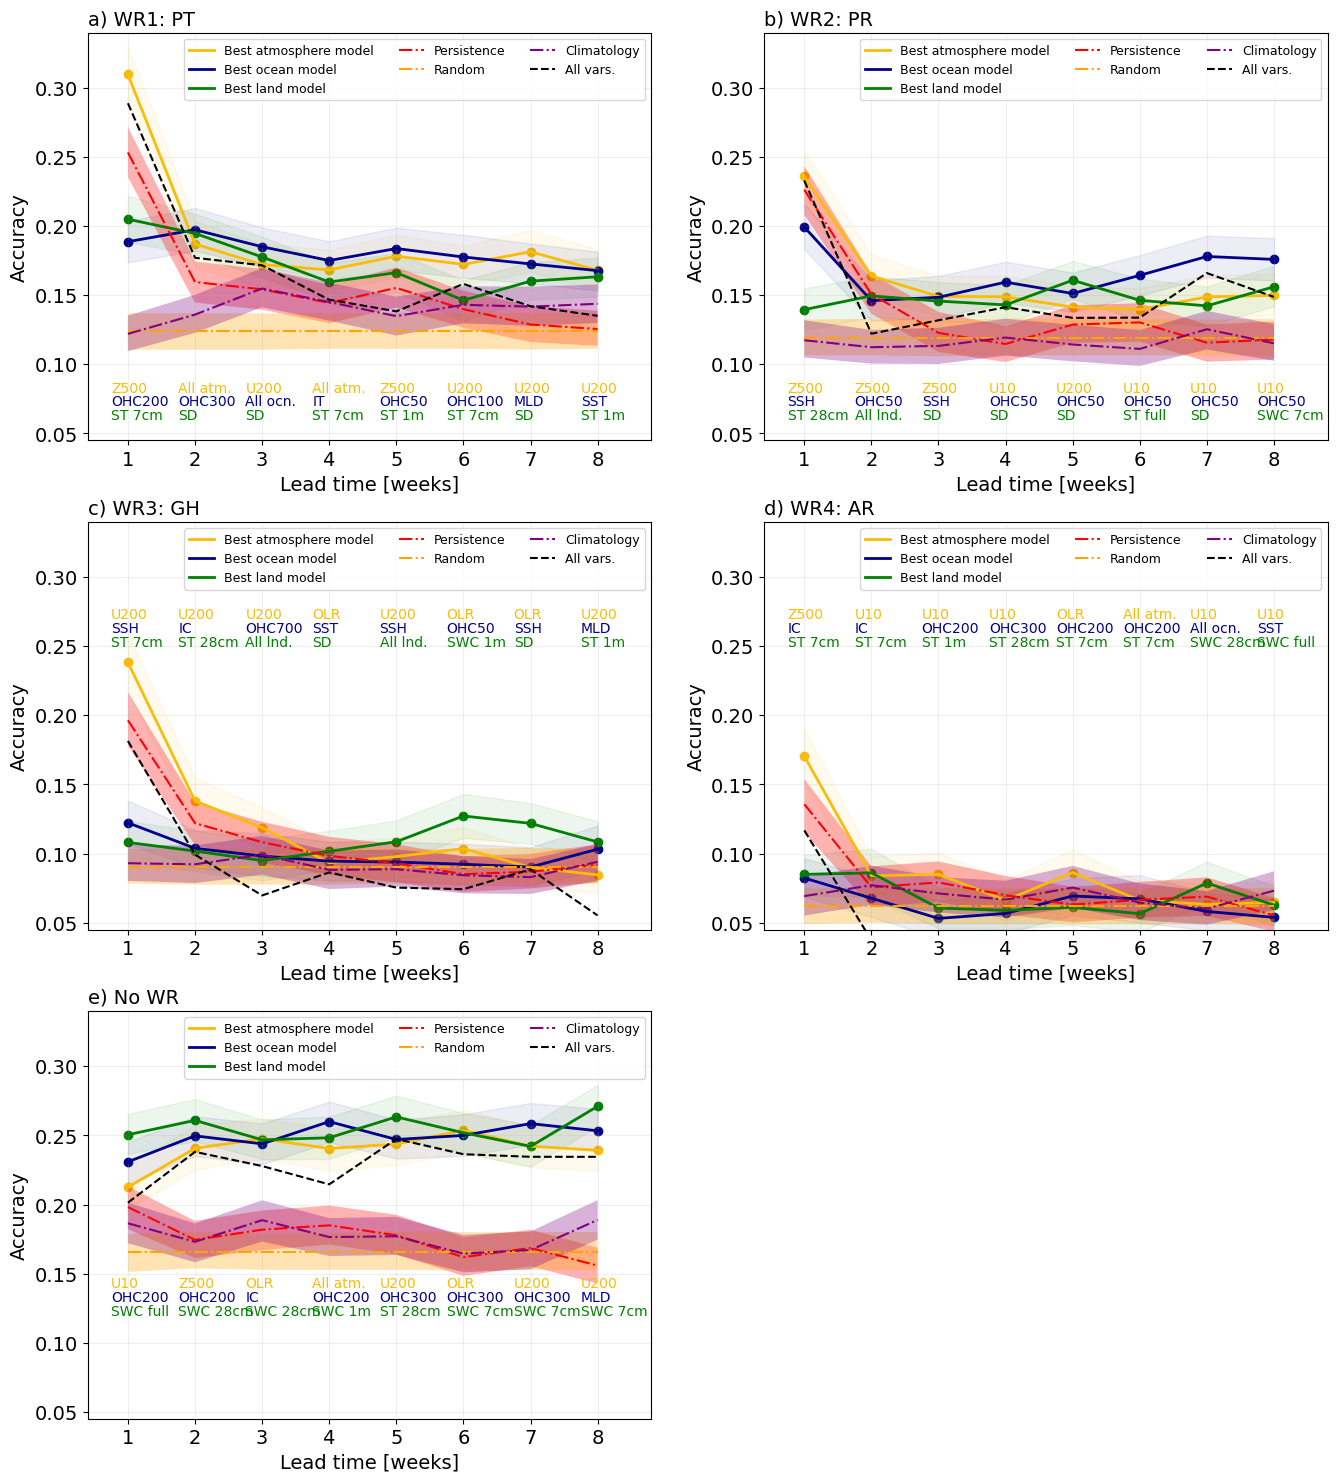

In [15]:
lower_ylim = 0.08
upper_ylim = 0.4

# Create a figure and a set of subplots
fig, axs = plt.subplots(3, 2,figsize=(16,18))  # 2x2 grid of subplots

# Flatten the axs array and convert to list
axs_list = axs.flatten().tolist()

for weather_regime, weather_regime_name in enumerate(names_wr):
    dic_atm = {}
    dic_atm['all_f1s'] = []
    dic_atm['names'] = []
    
    for ivar in indices_vars_atm:
        dic_atm['all_f1s'].append(np.load(f'{path_f1s_wrs}f1_{list_vars[ivar]}_wr{weather_regime}.npy'))
        dic_atm['names'].append(list_vars[ivar])
    dic_atm['all_f1s'].append(np.load(f'{path_f1s_wrs}/f1_atm_wr{weather_regime}.npy'))
    dic_atm['names'].append(f'All atm.')
    
    dic_atm['all_f1s'] = np.array(dic_atm['all_f1s'])
    dic_atm['names'] = np.array(dic_atm['names'])
    dic_atm['best_model'] = dic_atm['names'][dic_atm['all_f1s'][:,:,0].argmax(axis=0)]
    
    dic_ocn = {}
    dic_ocn['all_f1s'] = []
    dic_ocn['names'] = []
    
    for ivar in indices_vars_ocn:
        dic_ocn['all_f1s'].append(np.load(f'{path_f1s_wrs}f1_{list_vars[ivar]}_wr{weather_regime}.npy'))
        dic_ocn['names'].append(list_vars[ivar])
    dic_ocn['all_f1s'].append(np.load(f'{path_f1s_wrs}/f1_ocn_wr{weather_regime}.npy'))
    dic_ocn['names'].append(f'All ocn.')
    
    dic_ocn['all_f1s'] = np.array(dic_ocn['all_f1s'])
    dic_ocn['names'] = np.array(dic_ocn['names'])
    dic_ocn['best_model'] = dic_ocn['names'][dic_ocn['all_f1s'][:,:,0].argmax(axis=0)]
    
    dic_lnd = {}
    dic_lnd['all_f1s'] = []
    dic_lnd['names'] = []
    
    for ivar in indices_vars_lnd:
        dic_lnd['all_f1s'].append(np.load(f'{path_f1s_wrs}f1_{list_vars[ivar]}_wr{weather_regime}.npy'))
        dic_lnd['names'].append(list_vars[ivar])
    dic_lnd['all_f1s'].append(np.load(f'{path_f1s_wrs}/f1_lnd_wr{weather_regime}.npy'))
    dic_lnd['names'].append(f'All lnd.')
    
    dic_lnd['all_f1s'] = np.array(dic_lnd['all_f1s'])
    dic_lnd['names'] = np.array(dic_lnd['names'])
    dic_lnd['best_model'] = dic_lnd['names'][dic_lnd['all_f1s'][:,:,0].argmax(axis=0)]
    
    f1_persistence = np.load(f'{path_f1s_wrs}f1_persistence_wr{weather_regime}.npy')
    f1_climatology = np.load(f'{path_f1s_wrs}f1_climatology_wr{weather_regime}.npy')
    f1_random = np.load(f'{path_f1s_wrs}f1_random_wr{weather_regime}.npy')
    f1_all = np.load(f'{path_f1s_wrs}/f1_all_wr{weather_regime}.npy')
    weeks = np.arange(1,9)

    ##### PLOT

    best_f1_atm = np.array([dic_atm['all_f1s'][iwhere, iweek]\
                        for iweek, iwhere in enumerate(dic_atm['all_f1s'][:,:,0].argmax(axis=0))])
    
    best_f1_ocn = np.array([dic_ocn['all_f1s'][iwhere, iweek]\
                        for iweek, iwhere in enumerate(dic_ocn['all_f1s'][:,:,0].argmax(axis=0))])
    
    best_f1_lnd = np.array([dic_lnd['all_f1s'][iwhere, iweek]\
                        for iweek, iwhere in enumerate(dic_lnd['all_f1s'][:,:,0].argmax(axis=0))])
    
    axs_list[weather_regime].plot(weeks,best_f1_atm[:,0],label=f'Best atmosphere model',color='#f9bc08',lw=2)
    axs_list[weather_regime].scatter(weeks,best_f1_atm[:,0],color='#f9bc08')#, s=diff*100)
    
    axs_list[weather_regime].plot(weeks,best_f1_ocn[:,0],label=f'Best ocean model',color='darkblue',lw=2)
    axs_list[weather_regime].scatter(weeks,best_f1_ocn[:,0],color='darkblue')
    
    axs_list[weather_regime].plot(weeks,best_f1_lnd[:,0],label=f'Best land model',color='green',lw=2)
    axs_list[weather_regime].scatter(weeks,best_f1_lnd[:,0],color='green')
    
    axs_list[weather_regime].fill_between(weeks, best_f1_atm[:,1], 
                     best_f1_atm[:,2], color='#f9bc08', alpha=0.07)
    axs_list[weather_regime].fill_between(weeks, best_f1_ocn[:,1], 
                     best_f1_ocn[:,2], color='darkblue', alpha=0.07)
    axs_list[weather_regime].fill_between(weeks, best_f1_lnd[:,1], 
                     best_f1_lnd[:,2], color='green', alpha=0.07)
    
    # Plot benchmarks
    axs_list[weather_regime].plot(weeks, f1_persistence[:,0], color='red', label='Persistence', ls='dashdot')
    axs_list[weather_regime].fill_between(weeks, f1_persistence[:,1],f1_persistence[:,2], 
                          color='red', ls='dashdot', lw=0.01,alpha=0.3)
    
    
    axs_list[weather_regime].plot(weeks, f1_random[:,0], color='orange', label='Random', ls='dashdot')
    axs_list[weather_regime].fill_between(weeks, f1_random[:,1],f1_random[:,2], 
                          color='orange', ls='dashdot', lw=0.01,alpha=0.3)
    
    axs_list[weather_regime].plot(weeks, f1_climatology[:,0], color='purple', label='Climatology', ls='dashdot')
    axs_list[weather_regime].fill_between(weeks, f1_climatology[:,1],f1_climatology[:,2], 
                          color='purple', ls='dashdot', lw=0.01,alpha=0.3)
    ## Plot joint model
    axs_list[weather_regime].plot(weeks, f1_all[:,0], color='k', label='All vars.', ls='dashed')
    
    constant = -0.12
    if weather_regime==2:
        constant = 0.07
    if weather_regime==3:
        constant = 0.07
    if weather_regime==4:
        constant = -0.06
    # Plot best model
    for i, j, d in zip(weeks, best_f1_atm[:,0], dic_atm['best_model'][:]):
        axs_list[weather_regime].text(i - 0.25, 0.20+constant, s=d.replace('_ERA5',''), 
                      color = '#f9bc08',fontsize=10)
    for i, j, d in zip(weeks, best_f1_ocn[:,0], dic_ocn['best_model'][:]):
        axs_list[weather_regime].text(i - 0.25, 0.19+constant, s=d.replace('_SODA','').replace('_OISSTv2','')\
                      .replace('_wT',' \nwT'), 
                      color = 'darkblue',fontsize=10)
    for i, j, d in zip(weeks, best_f1_lnd[:,0], dic_lnd['best_model'][:]):
        axs_list[weather_regime].text(i - 0.25,  0.18+constant, s=d.replace('SWVL','SWC').replace('STL','ST')\
                      .replace('_ERA5','').replace('_',' ').replace(' wT',' \nwT'), 
                      color = 'green',fontsize=10)
    
    axs_list[weather_regime].set_xlim(0.4, 8.8)
    axs_list[weather_regime].set_ylim(0.045, 0.34)
    axs_list[weather_regime].tick_params(axis='both', which='major', labelsize=14)
    axs_list[weather_regime].grid(alpha=0.2)
    axs_list[weather_regime].set_ylabel('Accuracy',fontsize=14)
    axs_list[weather_regime].set_xlabel('Lead time [weeks]',fontsize=14)
    abcd = list(string.ascii_lowercase)
    axs_list[weather_regime].set_title(f'{abcd[weather_regime]}) {weather_regime_name}', loc='left',fontsize=14)
    axs_list[weather_regime].legend(bbox_to_anchor=(1, 1.0), fontsize=9,ncol=3)

axs_list[-1].remove()
# plt.savefig('Figures/3_f1WRs.png',bbox_inches='tight')

# WR-dependent performance seasonally

In [16]:
path_f1s_wrs_seasonal = '/glade/derecho/scratch/jhayron/Data4Predictability/ResultsXGBoost/F1s_v20241226/f1s_wrs_seasonal/'

In [17]:
for iseason, season in enumerate(indices_seasons.keys()):
    print(season)
    for weather_regime, weather_regime_name in enumerate(names_wr):
        print(weather_regime)
        for ivar in all_indices:
        # for ivar in [8]:
            # print(list_vars[ivar])
            results_weeks = {}
            results_probs_weeks = {}
            
            for week_out in range(1,9):
                # print(f'WEEK: {week_out}')
                week_out_str = f'week{week_out}'
                df_results_full = pd.read_csv(f'{path_results}Results_{list_vars[ivar]}_{week_out_str}.csv',
                                             index_col=0, parse_dates=True)
                #### Filter by wr ####
                df_results_full = df_results_full.loc[(df_results_full['y_true']==weather_regime)\
                    |(df_results_full['y_predicted']==weather_regime)]
                #### Filter by season ####
                df_results_full = df_results_full.loc[(df_results_full.index.month==indices_seasons[season][0])|\
                                (df_results_full.index.month==indices_seasons[season][1])|\
                                (df_results_full.index.month==indices_seasons[season][2])]
                ##########################
                results_weeks[week_out_str] = df_results_full
        
            f1_xgb = []
            if ivar==8:
                f1_persistence = []
                f1_climatology = []
                f1_random = []
            
            for week_out in range(1,9):
                # week_out = 5
                week_out_str = f'week{week_out}'
                df_week_forecast = df_shifts[[week_out_str]].dropna()
                random_forecast = generate_random_forecast(df_week_forecast, seed_value=42)    
                climatology_forecast = generate_random_forecast_with_monthly_probabilities(df_week_forecast, seed_value=42)
    
                df_results_temp = results_weeks[week_out_str]
    
                persistence_forecast = copy.deepcopy(df_shifts[['week0',week_out_str]]).dropna()
                persistence_forecast.columns = ['y_predicted','y_true']
                df_results_temp_persistence = persistence_forecast.loc[(persistence_forecast['y_true']==weather_regime)\
                    |(persistence_forecast['y_predicted']==weather_regime)]
                df_results_temp_persistence = df_results_temp_persistence.loc[(df_results_temp_persistence.index.month==indices_seasons[season][0])|\
                                (df_results_temp_persistence.index.month==indices_seasons[season][1])|\
                                (df_results_temp_persistence.index.month==indices_seasons[season][2])]
                
                random_forecast['y_true'] = df_shifts[week_out_str].loc[random_forecast.index]
                climatology_forecast['y_true'] = df_shifts[week_out_str].loc[climatology_forecast.index]
                
                df_results_temp_random = random_forecast.loc[(random_forecast['y_true']==weather_regime)\
                    |(random_forecast['y_predicted']==weather_regime)]
                df_results_temp_random = df_results_temp_random.loc[(df_results_temp_random.index.month==indices_seasons[season][0])|\
                                (df_results_temp_random.index.month==indices_seasons[season][1])|\
                                (df_results_temp_random.index.month==indices_seasons[season][2])]
                
                df_results_temp_clima = climatology_forecast.loc[(climatology_forecast['y_true']==weather_regime)\
                    |(climatology_forecast['y_predicted']==weather_regime)]
                df_results_temp_clima = df_results_temp_clima.loc[(df_results_temp_clima.index.month==indices_seasons[season][0])|\
                                (df_results_temp_clima.index.month==indices_seasons[season][1])|\
                                (df_results_temp_clima.index.month==indices_seasons[season][2])]
    
                f1_xgb.append(compute_accuracy_and_range(df_results_temp))
                if ivar==8:
                    f1_persistence.append(compute_accuracy_and_range(df_results_temp_persistence))
                    f1_climatology.append(compute_accuracy_and_range(df_results_temp_clima))
                    f1_random.append(compute_accuracy_and_range(df_results_temp_random))
            
            f1_xgb = np.array(f1_xgb)
            if ivar==8:
                f1_persistence = np.array(f1_persistence)
                f1_climatology = np.array(f1_climatology)
                f1_random = np.array(f1_random)
                np.save(f'{path_f1s_wrs_seasonal}/f1_persistence_wr{weather_regime}_{season}.npy',f1_persistence)
                np.save(f'{path_f1s_wrs_seasonal}/f1_climatology_wr{weather_regime}_{season}.npy',f1_climatology)
                np.save(f'{path_f1s_wrs_seasonal}/f1_random_wr{weather_regime}_{season}.npy',f1_random)
        
            np.save(f'{path_f1s_wrs_seasonal}/f1_{list_vars[ivar]}_wr{weather_regime}_{season}.npy',f1_xgb)

Winter
0
1
2
3
4
Spring
0
1
2
3
4
Summer
0
1
2
3
4
Fall
0
1
2
3
4


In [18]:
for iseason, season in enumerate(indices_seasons.keys()):
    print(season)
    for weather_regime, weather_regime_name in enumerate(names_wr):
        print(weather_regime)
        for component in ['atm','ocn','lnd','all']:
            # print(component)
            
            path_weekly_anoms = '/glade/derecho/scratch/jhayron/Data4Predictability/WeeklyAnoms_DetrendedStd_v3_2dg/'
        
            results_weeks = {}
            results_probs_weeks = {}
            
            for week_out in range(1,9):
                # print(f'WEEK: {week_out}')
                week_out_str = f'week{week_out}'
                df_results_full = pd.read_csv(f'{path_results}Results_{component}_{week_out_str}.csv',
                                             index_col=0, parse_dates=True)
                #### Filter by wr ####
                df_results_full = df_results_full.loc[(df_results_full['y_true']==weather_regime)\
                    |(df_results_full['y_predicted']==weather_regime)]
                #### Filter by season ####
                df_results_full = df_results_full.loc[(df_results_full.index.month==indices_seasons[season][0])|\
                                (df_results_full.index.month==indices_seasons[season][1])|\
                                (df_results_full.index.month==indices_seasons[season][2])]
        
                results_weeks[week_out_str] = df_results_full
        
            f1_xgb = []
        
            for week_out in range(1,9):
                # week_out = 5
                week_out_str = f'week{week_out}'
                df_results_temp = results_weeks[week_out_str]
                
                f1_xgb.append(compute_accuracy_and_range(df_results_temp))
            
            f1_xgb = np.array(f1_xgb)
            np.save(f'{path_f1s_wrs_seasonal}/f1_{component}_wr{weather_regime}_{season}.npy',f1_xgb)

Winter
0
1
2
3
4
Spring
0
1
2
3
4
Summer
0
1
2
3
4
Fall
0
1
2
3
4


WR1: PT
Winter
['Z500_ERA5' 'All atm.' 'OLR_ERA5' 'Z500_ERA5' 'OLR_ERA5' 'All atm.'
 'U200_ERA5' 'U200_ERA5']
['SSH_SODA' 'OHC300_SODA' 'OHC200_SODA' 'OHC300_SODA' 'OHC50_SODA'
 'OHC100_SODA' 'OHC200_SODA' 'OHC50_SODA']
['STL_7cm_ERA5' 'SD_ERA5' 'SD_ERA5' 'All lnd.' 'STL_28cm_ERA5'
 'STL_full_ERA5' 'STL_full_ERA5' 'STL_full_ERA5']
Spring
['U200_ERA5' 'U200_ERA5' 'U10_ERA5' 'All atm.' 'U10_ERA5' 'U200_ERA5'
 'U10_ERA5' 'Z500_ERA5']
['OHC200_SODA' 'OHC50_SODA' 'OHC50_SODA' 'OHC300_SODA' 'OHC200_SODA'
 'OHC300_SODA' 'MLD_SODA' 'IC_SODA']
['All lnd.' 'STL_full_ERA5' 'SD_ERA5' 'STL_1m_ERA5' 'STL_1m_ERA5'
 'STL_1m_ERA5' 'STL_1m_ERA5' 'STL_1m_ERA5']
Summer
['U200_ERA5' 'Z500_ERA5' 'U200_ERA5' 'All atm.' 'Z500_ERA5' 'U10_ERA5'
 'OLR_ERA5' 'Z500_ERA5']
['All ocn.' 'OHC300_SODA' 'IT_SODA' 'IT_SODA' 'IT_SODA' 'IT_SODA'
 'IT_SODA' 'IT_SODA']
['SD_ERA5' 'SD_ERA5' 'STL_1m_ERA5' 'SWVL_full_ERA5' 'SD_ERA5'
 'SWVL_1m_ERA5' 'SD_ERA5' 'SWVL_1m_ERA5']
Fall
['Z500_ERA5' 'OLR_ERA5' 'All atm.' 'All atm.' 'Z5

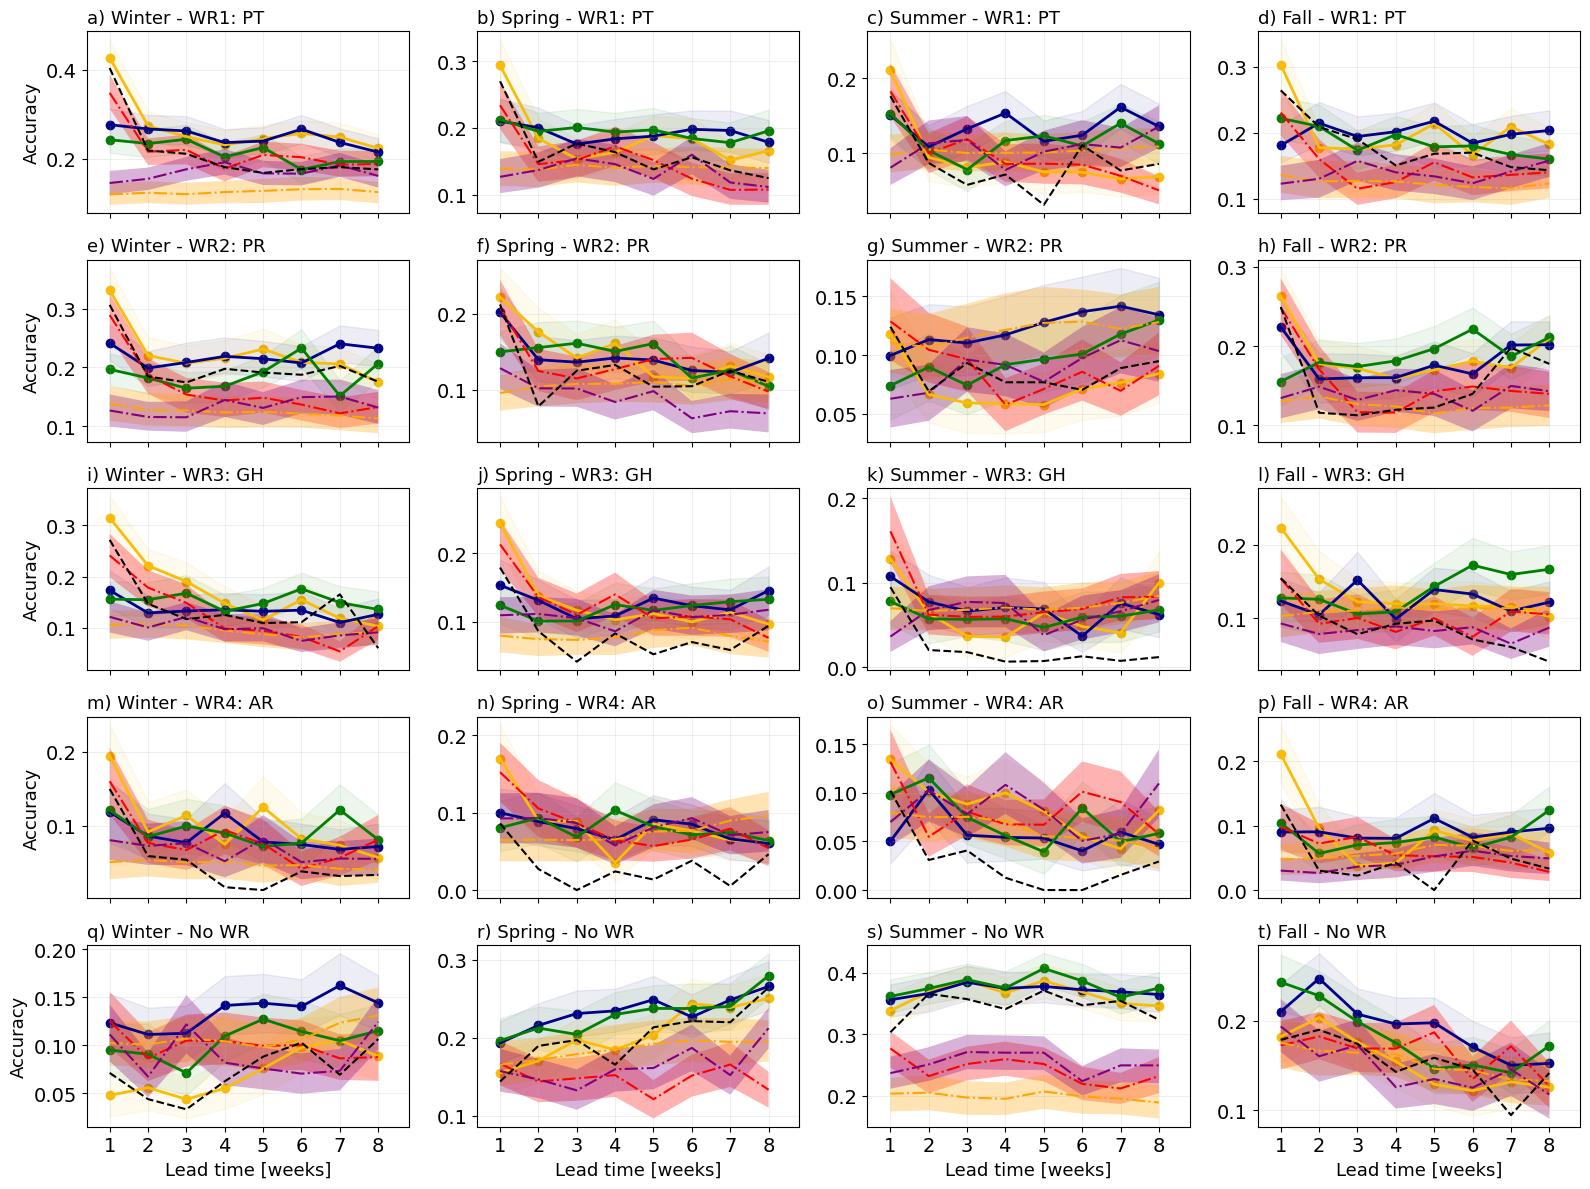

In [19]:
alphabet = list(string.ascii_lowercase)
weeks = np.arange(1, 9)

# Create a figure and a set of subplots
fig, axs = plt.subplots(5, 4, figsize=(16, 12))  # 4x4 grid of subplots
axs_list = axs.flatten().tolist()

counter2 = 0
for weather_regime, weather_regime_name in enumerate(names_wr):
    print(weather_regime_name)
    wr = weather_regime
    for iseason, season in enumerate(indices_seasons.keys()):
        print(season)
        dic_atm = {}
        dic_atm['all_f1s'] = []
        dic_atm['names'] = []
        
        for ivar in indices_vars_atm:
            dic_atm['all_f1s'].append(np.load(f'{path_f1s_wrs_seasonal}f1_{list_vars[ivar]}_wr{weather_regime}_{season}.npy'))
            dic_atm['names'].append(list_vars[ivar])
        dic_atm['all_f1s'].append(np.load(f'{path_f1s_wrs_seasonal}/f1_atm_wr{weather_regime}_{season}.npy'))
        dic_atm['names'].append(f'All atm.')
        
        dic_atm['all_f1s'] = np.array(dic_atm['all_f1s'])
        dic_atm['names'] = np.array(dic_atm['names'])
        dic_atm['best_model'] = dic_atm['names'][dic_atm['all_f1s'][:,:,0].argmax(axis=0)]
        
        dic_ocn = {}
        dic_ocn['all_f1s'] = []
        dic_ocn['names'] = []
        
        for ivar in indices_vars_ocn:
            dic_ocn['all_f1s'].append(np.load(f'{path_f1s_wrs_seasonal}f1_{list_vars[ivar]}_wr{weather_regime}_{season}.npy'))
            dic_ocn['names'].append(list_vars[ivar])
        dic_ocn['all_f1s'].append(np.load(f'{path_f1s_wrs_seasonal}/f1_ocn_wr{weather_regime}_{season}.npy'))
        dic_ocn['names'].append(f'All ocn.')
        
        dic_ocn['all_f1s'] = np.array(dic_ocn['all_f1s'])
        dic_ocn['names'] = np.array(dic_ocn['names'])
        dic_ocn['best_model'] = dic_ocn['names'][dic_ocn['all_f1s'][:,:,0].argmax(axis=0)]
        
        dic_lnd = {}
        dic_lnd['all_f1s'] = []
        dic_lnd['names'] = []
        
        for ivar in indices_vars_lnd:
            dic_lnd['all_f1s'].append(np.load(f'{path_f1s_wrs_seasonal}f1_{list_vars[ivar]}_wr{weather_regime}_{season}.npy'))
            dic_lnd['names'].append(list_vars[ivar])
        dic_lnd['all_f1s'].append(np.load(f'{path_f1s_wrs_seasonal}/f1_lnd_wr{weather_regime}_{season}.npy'))
        dic_lnd['names'].append(f'All lnd.')
        
        dic_lnd['all_f1s'] = np.array(dic_lnd['all_f1s'])
        dic_lnd['names'] = np.array(dic_lnd['names'])
        dic_lnd['best_model'] = dic_lnd['names'][dic_lnd['all_f1s'][:,:,0].argmax(axis=0)]
        
        f1_persistence = np.load(f'{path_f1s_wrs_seasonal}f1_persistence_wr{weather_regime}_{season}.npy')
        f1_climatology = np.load(f'{path_f1s_wrs_seasonal}f1_climatology_wr{weather_regime}_{season}.npy')
        f1_random = np.load(f'{path_f1s_wrs_seasonal}f1_random_wr{weather_regime}_{season}.npy')
        f1_all = np.load(f'{path_f1s_wrs_seasonal}/f1_all_wr{weather_regime}_{season}.npy')
    
        best_f1_atm = np.array([dic_atm['all_f1s'][iwhere, iweek]\
                            for iweek, iwhere in enumerate(dic_atm['all_f1s'][:,:,0].argmax(axis=0))])
        
        best_f1_ocn = np.array([dic_ocn['all_f1s'][iwhere, iweek]\
                            for iweek, iwhere in enumerate(dic_ocn['all_f1s'][:,:,0].argmax(axis=0))])
        
        best_f1_lnd = np.array([dic_lnd['all_f1s'][iwhere, iweek]\
                            for iweek, iwhere in enumerate(dic_lnd['all_f1s'][:,:,0].argmax(axis=0))])

        print(dic_atm['best_model'])
        print(dic_ocn['best_model'])
        print(dic_lnd['best_model'])
        
        axs_list[counter2].plot(weeks,best_f1_atm[:,0],label=f'Best atmosphere model',color='#f9bc08',lw=2)
        axs_list[counter2].scatter(weeks,best_f1_atm[:,0],color='#f9bc08')#, s=diff*100)
        
        axs_list[counter2].plot(weeks,best_f1_ocn[:,0],label=f'Best ocean model',color='darkblue',lw=2)
        axs_list[counter2].scatter(weeks,best_f1_ocn[:,0],color='darkblue')
        
        axs_list[counter2].plot(weeks,best_f1_lnd[:,0],label=f'Best land model',color='green',lw=2)
        axs_list[counter2].scatter(weeks,best_f1_lnd[:,0],color='green')
        
        axs_list[counter2].fill_between(weeks, best_f1_atm[:,1], 
                         best_f1_atm[:,2], color='#f9bc08', alpha=0.07)
        axs_list[counter2].fill_between(weeks, best_f1_ocn[:,1], 
                         best_f1_ocn[:,2], color='darkblue', alpha=0.07)
        axs_list[counter2].fill_between(weeks, best_f1_lnd[:,1], 
                         best_f1_lnd[:,2], color='green', alpha=0.07)
        
        # Plot benchmarks
        axs_list[counter2].plot(weeks, f1_persistence[:,0], color='red', label='Persistence', ls='dashdot')
        axs_list[counter2].fill_between(weeks, f1_persistence[:,1],f1_persistence[:,2], 
                              color='red', ls='dashdot', lw=0.01,alpha=0.3)
        
        
        axs_list[counter2].plot(weeks, f1_random[:,0], color='orange', label='Random', ls='dashdot')
        axs_list[counter2].fill_between(weeks, f1_random[:,1],f1_random[:,2], 
                              color='orange', ls='dashdot', lw=0.01,alpha=0.3)
        
        axs_list[counter2].plot(weeks, f1_climatology[:,0], color='purple', label='Climatology', ls='dashdot')
        axs_list[counter2].fill_between(weeks, f1_climatology[:,1],f1_climatology[:,2], 
                              color='purple', ls='dashdot', lw=0.01,alpha=0.3)
        ## Plot joint model
        axs_list[counter2].plot(weeks, f1_all[:,0], color='k', label='All vars.', ls='dashed')
        
        # constant = -0.12
        # if weather_regime==2:
        #     constant = 0.07
        # if weather_regime==3:
        #     constant = 0.07
        # if weather_regime==4:
        #     constant = -0.06
        # # Plot best model
        # for i, j, d in zip(weeks, best_f1_atm[:,0], dic_atm['best_model'][:]):
        #     axs_list[counter2].text(i - 0.25, 0.20+constant, s=d.replace('_ERA5',''), 
        #                   color = '#f9bc08',fontsize=10)
        # for i, j, d in zip(weeks, best_f1_ocn[:,0], dic_ocn['best_model'][:]):
        #     axs_list[counter2].text(i - 0.25, 0.19+constant, s=d.replace('_SODA','').replace('_OISSTv2','')\
        #                   .replace('_wT',' \nwT'), 
        #                   color = 'darkblue',fontsize=10)
        # for i, j, d in zip(weeks, best_f1_lnd[:,0], dic_lnd['best_model'][:]):
        #     axs_list[counter2].text(i - 0.25,  0.18+constant, s=d.replace('SWVL','SWC').replace('STL','ST')\
        #                   .replace('_ERA5','').replace('_',' ').replace(' wT',' \nwT'), 
        #                   color = 'green',fontsize=10)
        
        axs_list[counter2].set_xlim(0.4, 8.8)
        # axs_list[counter2].set_ylim(0.0, 0.45)
        axs_list[counter2].tick_params(axis='both', which='major', labelsize=14)
        axs_list[counter2].grid(alpha=0.2)
        # axs_list[counter2].set_ylabel('F1 Score',fontsize=14)
        # axs_list[counter2].set_xlabel('Lead time [weeks]',fontsize=14)
        abcd = list(string.ascii_lowercase)
        axs_list[counter2].set_title(f'{abcd[weather_regime]}) {weather_regime_name}', loc='left',fontsize=14)
        # axs_list[counter2].legend(bbox_to_anchor=(1, 1.0), fontsize=9,ncol=3)

        if iseason % 4 == 0:
            axs_list[counter2].set_ylabel("Accuracy", fontsize=13)
            axs_list[counter2].tick_params(axis='both', which='major', labelsize=14)
        # else:
        #     axs_list[counter2].tick_params(labelleft=False)
        if wr == 4:
            axs_list[counter2].set_xlabel("Lead time [weeks]", fontsize=13)
            axs_list[counter2].set_xticks(np.arange(1, 9))
            axs_list[counter2].tick_params(axis='both', which='major', labelsize=14)
        else:
            axs_list[counter2].set_xticks(np.arange(1, 9))
            axs_list[counter2].tick_params(labelbottom=False)
        
        # Calculate the counter based on row and column position
        # counter = iseason + wr * len(seasons)
        
        axs_list[counter2].set_title(f"{alphabet[counter2]}) {season} - {names_wr[wr]}", loc="left", fontsize=13)
        counter2 += 1
plt.tight_layout()


# Predictability starting from different weather regimes

In [20]:
path_f1s_starting_wrs = '/glade/derecho/scratch/jhayron/Data4Predictability/ResultsXGBoost/F1s_v20241226/f1s_startwrs/'

In [21]:
for weather_regime, weather_regime_name in enumerate(names_wr):
    for ivar in all_indices:
    # for ivar in [8]:
        print(list_vars[ivar])
        results_weeks = {}
        results_probs_weeks = {}
        
        for week_out in range(1,9):
            # print(f'WEEK: {week_out}')
            week_out_str = f'week{week_out}'
            df_results_full = pd.read_csv(f'{path_results}Results_{list_vars[ivar]}_{week_out_str}.csv',
                                         index_col=0, parse_dates=True)
            #### Filter by starting wr ####
            df_results_full['week0'] = df_shifts['week0'].loc[df_results_full.index].values
            df_results_full = df_results_full.loc[(df_results_full['week0']==weather_regime)]
            ##########################
            results_weeks[week_out_str] = df_results_full
    
        f1_xgb = []
        if ivar==8:
            f1_persistence = []
            f1_climatology = []
            f1_random = []
        
        for week_out in range(1,9):
            week_out_str = f'week{week_out}'
            df_week_forecast = df_shifts[[week_out_str]].dropna()
            random_forecast = generate_random_forecast(df_week_forecast, seed_value=42)    
            climatology_forecast = generate_random_forecast_with_monthly_probabilities(df_week_forecast, seed_value=42)
            
            df_results_temp = results_weeks[week_out_str]
            
            df_results_temp_persistence = copy.deepcopy(df_results_temp)
            df_week_0 = df_shifts[['week0']].dropna()
            df_results_temp_persistence['y_predicted'] = df_week_0.loc[df_results_temp['y_true'].index].values
            
            df_results_temp_random = copy.deepcopy(df_results_temp)
            df_results_temp_random['y_predicted'] = random_forecast.loc[df_results_temp['y_true'].index].values
            
            df_results_temp_clima = copy.deepcopy(df_results_temp)
            df_results_temp_clima['y_predicted'] = climatology_forecast.loc[df_results_temp['y_true'].index].values
            
            f1_xgb.append(compute_f1_and_range(df_results_temp))
            if ivar==8:
                f1_persistence.append(compute_f1_and_range(df_results_temp_persistence))
                f1_climatology.append(compute_f1_and_range(df_results_temp_clima))
                f1_random.append(compute_f1_and_range(df_results_temp_random))
        
        f1_xgb = np.array(f1_xgb)
        if ivar==8:
            f1_persistence = np.array(f1_persistence)
            f1_climatology = np.array(f1_climatology)
            f1_random = np.array(f1_random)
            np.save(f'{path_f1s_starting_wrs}/f1_persistence_wr{weather_regime}.npy',f1_persistence)
            np.save(f'{path_f1s_starting_wrs}/f1_climatology_wr{weather_regime}.npy',f1_climatology)
            np.save(f'{path_f1s_starting_wrs}/f1_random_wr{weather_regime}.npy',f1_random)
    
        np.save(f'{path_f1s_starting_wrs}/f1_{list_vars[ivar]}_wr{weather_regime}.npy',f1_xgb)
        

OLR_ERA5
U10_ERA5
U200_ERA5
Z500_ERA5
IC_SODA
IT_SODA
MLD_SODA
OHC100_SODA
OHC200_SODA
OHC300_SODA
OHC50_SODA
OHC700_SODA
SSH_SODA
SST_SODA
SD_ERA5
STL_1m_ERA5
STL_28cm_ERA5
STL_7cm_ERA5
STL_full_ERA5
SWVL_1m_ERA5
SWVL_28cm_ERA5
SWVL_7cm_ERA5
SWVL_full_ERA5
OLR_ERA5
U10_ERA5
U200_ERA5
Z500_ERA5
IC_SODA
IT_SODA
MLD_SODA
OHC100_SODA
OHC200_SODA
OHC300_SODA
OHC50_SODA
OHC700_SODA
SSH_SODA
SST_SODA
SD_ERA5
STL_1m_ERA5
STL_28cm_ERA5
STL_7cm_ERA5
STL_full_ERA5
SWVL_1m_ERA5
SWVL_28cm_ERA5
SWVL_7cm_ERA5
SWVL_full_ERA5
OLR_ERA5
U10_ERA5
U200_ERA5
Z500_ERA5
IC_SODA
IT_SODA
MLD_SODA
OHC100_SODA
OHC200_SODA
OHC300_SODA
OHC50_SODA
OHC700_SODA
SSH_SODA
SST_SODA
SD_ERA5
STL_1m_ERA5
STL_28cm_ERA5
STL_7cm_ERA5
STL_full_ERA5
SWVL_1m_ERA5
SWVL_28cm_ERA5
SWVL_7cm_ERA5
SWVL_full_ERA5
OLR_ERA5
U10_ERA5
U200_ERA5
Z500_ERA5
IC_SODA
IT_SODA
MLD_SODA
OHC100_SODA
OHC200_SODA
OHC300_SODA
OHC50_SODA
OHC700_SODA
SSH_SODA
SST_SODA
SD_ERA5
STL_1m_ERA5
STL_28cm_ERA5
STL_7cm_ERA5
STL_full_ERA5
SWVL_1m_ERA5
SWVL_28cm_ER

In [22]:
for weather_regime, weather_regime_name in enumerate(names_wr):
    for component in ['atm','ocn','lnd','all']:
        print(component)
        
        path_weekly_anoms = '/glade/derecho/scratch/jhayron/Data4Predictability/WeeklyAnoms_DetrendedStd_v3_2dg/'
    
        results_weeks = {}
        results_probs_weeks = {}
        
        for week_out in range(1,9):
            # print(f'WEEK: {week_out}')
            week_out_str = f'week{week_out}'
            df_results_full = pd.read_csv(f'{path_results}Results_{component}_{week_out_str}.csv',
                                         index_col=0, parse_dates=True)
            #### Filter by starting wr ####
            df_results_full['week0'] = df_shifts['week0'].loc[df_results_full.index].values
            df_results_full = df_results_full.loc[(df_results_full['week0']==weather_regime)]
    
            results_weeks[week_out_str] = df_results_full
    
        f1_xgb = []
    
        for week_out in range(1,9):
            # week_out = 5
            week_out_str = f'week{week_out}'
            df_results_temp = results_weeks[week_out_str]
            
            f1_xgb.append(compute_f1_and_range(df_results_temp))
        
        f1_xgb = np.array(f1_xgb)
        np.save(f'{path_f1s_starting_wrs}/f1_{component}_wr{weather_regime}.npy',f1_xgb)

atm
ocn
lnd
all
atm
ocn
lnd
all
atm
ocn
lnd
all
atm
ocn
lnd
all
atm
ocn
lnd
all


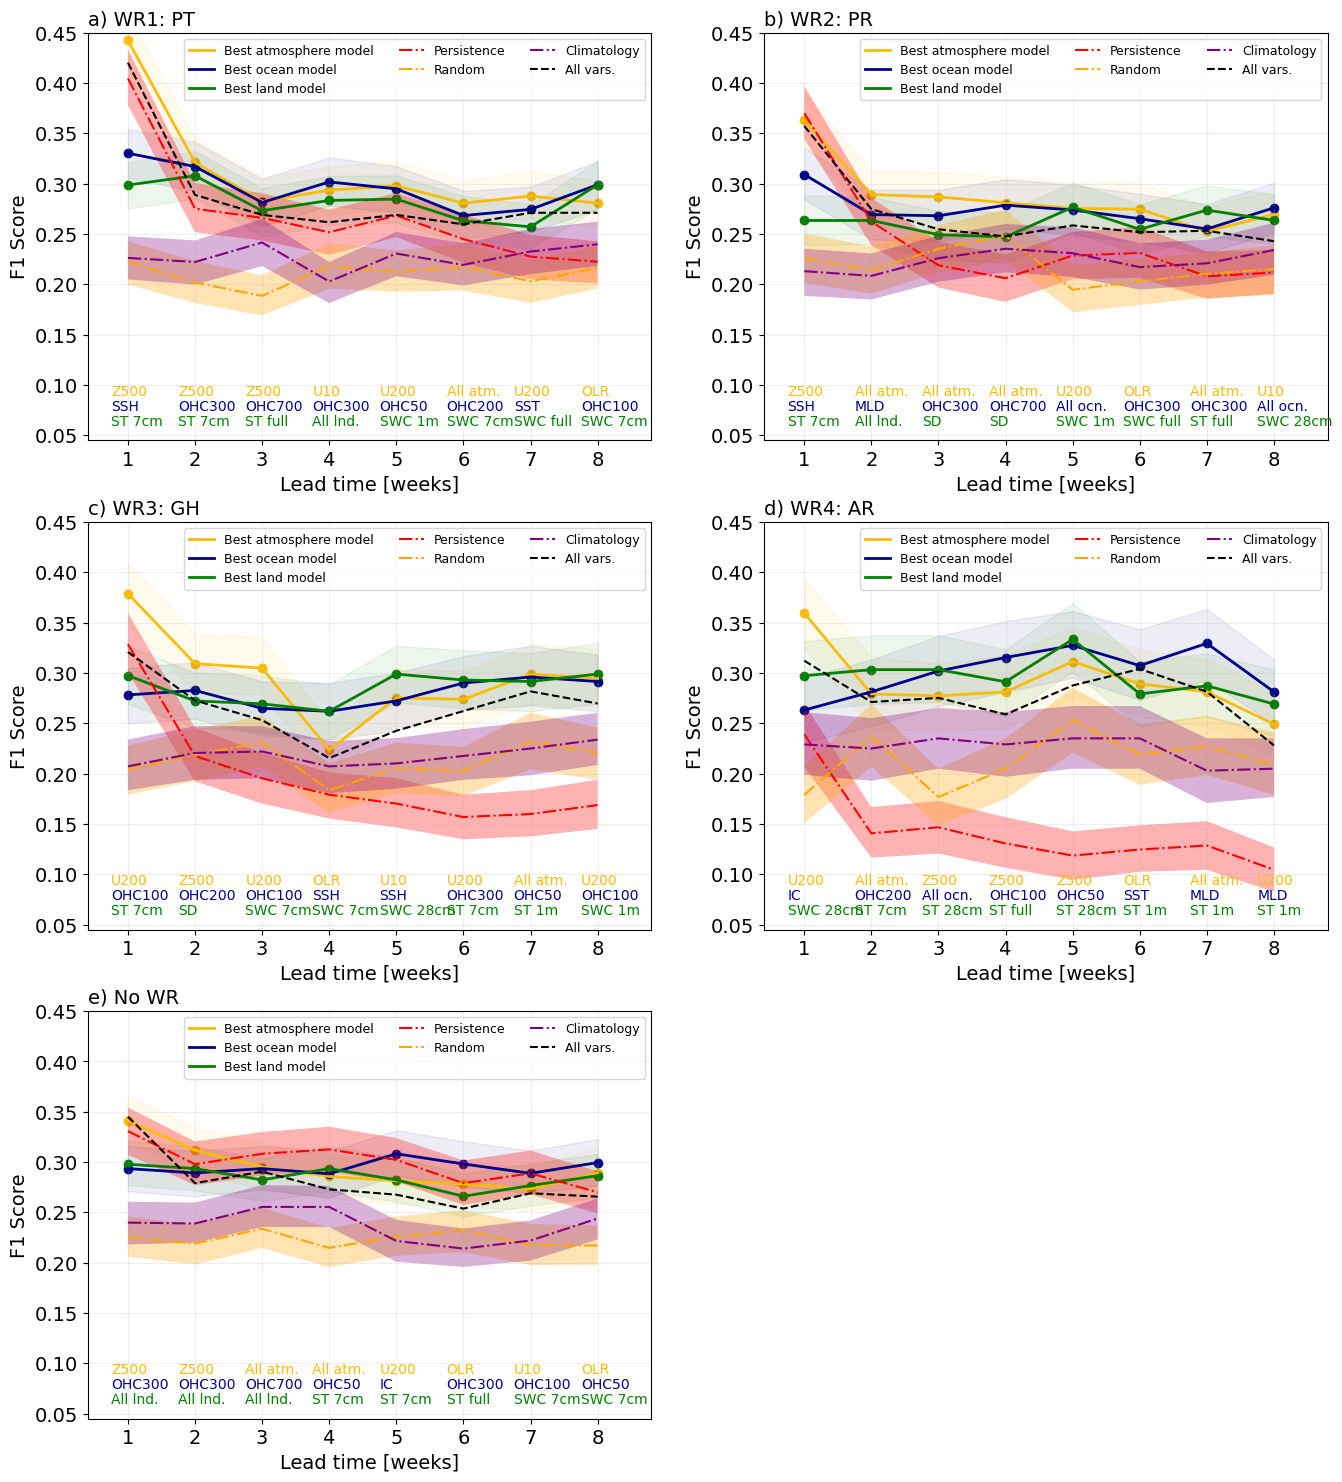

In [23]:
lower_ylim = 0.08
upper_ylim = 0.4

# Create a figure and a set of subplots
fig, axs = plt.subplots(3, 2,figsize=(16,18))  # 2x2 grid of subplots

# Flatten the axs array and convert to list
axs_list = axs.flatten().tolist()

for weather_regime, weather_regime_name in enumerate(names_wr):
    dic_atm = {}
    dic_atm['all_f1s'] = []
    dic_atm['names'] = []
    
    for ivar in indices_vars_atm:
        dic_atm['all_f1s'].append(np.load(f'{path_f1s_starting_wrs}f1_{list_vars[ivar]}_wr{weather_regime}.npy'))
        dic_atm['names'].append(list_vars[ivar])
    dic_atm['all_f1s'].append(np.load(f'{path_f1s_starting_wrs}/f1_atm_wr{weather_regime}.npy'))
    dic_atm['names'].append(f'All atm.')
    
    dic_atm['all_f1s'] = np.array(dic_atm['all_f1s'])
    dic_atm['names'] = np.array(dic_atm['names'])
    dic_atm['best_model'] = dic_atm['names'][dic_atm['all_f1s'][:,:,0].argmax(axis=0)]
    
    dic_ocn = {}
    dic_ocn['all_f1s'] = []
    dic_ocn['names'] = []
    
    for ivar in indices_vars_ocn:
        dic_ocn['all_f1s'].append(np.load(f'{path_f1s_starting_wrs}f1_{list_vars[ivar]}_wr{weather_regime}.npy'))
        dic_ocn['names'].append(list_vars[ivar])
    dic_ocn['all_f1s'].append(np.load(f'{path_f1s_starting_wrs}/f1_ocn_wr{weather_regime}.npy'))
    dic_ocn['names'].append(f'All ocn.')
    
    dic_ocn['all_f1s'] = np.array(dic_ocn['all_f1s'])
    dic_ocn['names'] = np.array(dic_ocn['names'])
    dic_ocn['best_model'] = dic_ocn['names'][dic_ocn['all_f1s'][:,:,0].argmax(axis=0)]
    
    dic_lnd = {}
    dic_lnd['all_f1s'] = []
    dic_lnd['names'] = []
    
    for ivar in indices_vars_lnd:
        dic_lnd['all_f1s'].append(np.load(f'{path_f1s_starting_wrs}f1_{list_vars[ivar]}_wr{weather_regime}.npy'))
        dic_lnd['names'].append(list_vars[ivar])
    dic_lnd['all_f1s'].append(np.load(f'{path_f1s_starting_wrs}/f1_lnd_wr{weather_regime}.npy'))
    dic_lnd['names'].append(f'All lnd.')
    
    dic_lnd['all_f1s'] = np.array(dic_lnd['all_f1s'])
    dic_lnd['names'] = np.array(dic_lnd['names'])
    dic_lnd['best_model'] = dic_lnd['names'][dic_lnd['all_f1s'][:,:,0].argmax(axis=0)]
    
    f1_persistence = np.load(f'{path_f1s_starting_wrs}f1_persistence_wr{weather_regime}.npy')
    f1_climatology = np.load(f'{path_f1s_starting_wrs}f1_climatology_wr{weather_regime}.npy')
    f1_random = np.load(f'{path_f1s_starting_wrs}f1_random_wr{weather_regime}.npy')
    f1_all = np.load(f'{path_f1s_starting_wrs}/f1_all_wr{weather_regime}.npy')
    weeks = np.arange(1,9)

    ##### PLOT

    best_f1_atm = np.array([dic_atm['all_f1s'][iwhere, iweek]\
                        for iweek, iwhere in enumerate(dic_atm['all_f1s'][:,:,0].argmax(axis=0))])
    
    best_f1_ocn = np.array([dic_ocn['all_f1s'][iwhere, iweek]\
                        for iweek, iwhere in enumerate(dic_ocn['all_f1s'][:,:,0].argmax(axis=0))])
    
    best_f1_lnd = np.array([dic_lnd['all_f1s'][iwhere, iweek]\
                        for iweek, iwhere in enumerate(dic_lnd['all_f1s'][:,:,0].argmax(axis=0))])
    
    axs_list[weather_regime].plot(weeks,best_f1_atm[:,0],label=f'Best atmosphere model',color='#f9bc08',lw=2)
    axs_list[weather_regime].scatter(weeks,best_f1_atm[:,0],color='#f9bc08')#, s=diff*100)
    
    axs_list[weather_regime].plot(weeks,best_f1_ocn[:,0],label=f'Best ocean model',color='darkblue',lw=2)
    axs_list[weather_regime].scatter(weeks,best_f1_ocn[:,0],color='darkblue')
    
    axs_list[weather_regime].plot(weeks,best_f1_lnd[:,0],label=f'Best land model',color='green',lw=2)
    axs_list[weather_regime].scatter(weeks,best_f1_lnd[:,0],color='green')
    
    axs_list[weather_regime].fill_between(weeks, best_f1_atm[:,1], 
                     best_f1_atm[:,2], color='#f9bc08', alpha=0.07)
    axs_list[weather_regime].fill_between(weeks, best_f1_ocn[:,1], 
                     best_f1_ocn[:,2], color='darkblue', alpha=0.07)
    axs_list[weather_regime].fill_between(weeks, best_f1_lnd[:,1], 
                     best_f1_lnd[:,2], color='green', alpha=0.07)
    
    # Plot benchmarks
    axs_list[weather_regime].plot(weeks, f1_persistence[:,0], color='red', label='Persistence', ls='dashdot')
    axs_list[weather_regime].fill_between(weeks, f1_persistence[:,1],f1_persistence[:,2], 
                          color='red', ls='dashdot', lw=0.01,alpha=0.3)
    
    
    axs_list[weather_regime].plot(weeks, f1_random[:,0], color='orange', label='Random', ls='dashdot')
    axs_list[weather_regime].fill_between(weeks, f1_random[:,1],f1_random[:,2], 
                          color='orange', ls='dashdot', lw=0.01,alpha=0.3)
    
    axs_list[weather_regime].plot(weeks, f1_climatology[:,0], color='purple', label='Climatology', ls='dashdot')
    axs_list[weather_regime].fill_between(weeks, f1_climatology[:,1],f1_climatology[:,2], 
                          color='purple', ls='dashdot', lw=0.01,alpha=0.3)
    ## Plot joint model
    axs_list[weather_regime].plot(weeks, f1_all[:,0], color='k', label='All vars.', ls='dashed')
    
    constant = -0.16

    # Plot best model
    for i, j, d in zip(weeks, best_f1_atm[:,0], dic_atm['best_model'][:]):
        axs_list[weather_regime].text(i - 0.25, 0.25+constant, s=d.replace('_ERA5',''), 
                      color = '#f9bc08',fontsize=10)
    for i, j, d in zip(weeks, best_f1_ocn[:,0], dic_ocn['best_model'][:]):
        axs_list[weather_regime].text(i - 0.25, 0.235+constant, s=d.replace('_SODA','').replace('_OISSTv2','')\
                      .replace('_wT',' \nwT'), 
                      color = 'darkblue',fontsize=10)
    for i, j, d in zip(weeks, best_f1_lnd[:,0], dic_lnd['best_model'][:]):
        axs_list[weather_regime].text(i - 0.25,  0.22+constant, s=d.replace('SWVL','SWC').replace('STL','ST')\
                      .replace('_ERA5','').replace('_',' ').replace(' wT',' \nwT'), 
                      color = 'green',fontsize=10)
    
    axs_list[weather_regime].set_xlim(0.4, 8.8)
    axs_list[weather_regime].set_ylim(0.045, 0.45)
    axs_list[weather_regime].tick_params(axis='both', which='major', labelsize=14)
    axs_list[weather_regime].grid(alpha=0.2)
    axs_list[weather_regime].set_ylabel('F1 Score',fontsize=14)
    axs_list[weather_regime].set_xlabel('Lead time [weeks]',fontsize=14)
    abcd = list(string.ascii_lowercase)
    axs_list[weather_regime].set_title(f'{abcd[weather_regime]}) {weather_regime_name}', loc='left',fontsize=14)
    axs_list[weather_regime].legend(bbox_to_anchor=(1, 1.0), fontsize=9,ncol=3)

axs_list[-1].remove()
# plt.savefig('Figures/3_f1WRs.png',bbox_inches='tight')

# Predictability starting in different WRs performance seasonally

In [24]:
path_f1s_starting_wrs_seasonal = '/glade/derecho/scratch/jhayron/Data4Predictability/ResultsXGBoost/F1s_v20241226/f1s_startwrs_seasonal/'

In [25]:
for iseason, season in enumerate(indices_seasons.keys()):
    print(season)
    for weather_regime, weather_regime_name in enumerate(names_wr):
        print(weather_regime)
        for ivar in all_indices:
        # for ivar in [8]:
            # print(list_vars[ivar])
            results_weeks = {}
            results_probs_weeks = {}
            
            for week_out in range(1,9):
                # print(f'WEEK: {week_out}')
                week_out_str = f'week{week_out}'
                df_results_full = pd.read_csv(f'{path_results}Results_{list_vars[ivar]}_{week_out_str}.csv',
                                             index_col=0, parse_dates=True)
                #### Filter by starting wr ####
                df_results_full['week0'] = df_shifts['week0'].loc[df_results_full.index].values
                df_results_full = df_results_full.loc[(df_results_full['week0']==weather_regime)]
                #### Filter by season ####
                df_results_full = df_results_full.loc[(df_results_full.index.month==indices_seasons[season][0])|\
                                (df_results_full.index.month==indices_seasons[season][1])|\
                                (df_results_full.index.month==indices_seasons[season][2])]
                ##########################
                results_weeks[week_out_str] = df_results_full
        
            f1_xgb = []
            if ivar==8:
                f1_persistence = []
                f1_climatology = []
                f1_random = []
            
            for week_out in range(1,9):
                # week_out = 5
                week_out_str = f'week{week_out}'
                df_week_forecast = df_shifts[[week_out_str]].dropna()
                random_forecast = generate_random_forecast(df_week_forecast, seed_value=42)    
                climatology_forecast = generate_random_forecast_with_monthly_probabilities(df_week_forecast, seed_value=42)
                
                df_results_temp = results_weeks[week_out_str]
                
                df_results_temp_persistence = copy.deepcopy(df_results_temp)
                df_week_0 = df_shifts[['week0']].dropna()
                df_results_temp_persistence['y_predicted'] = df_week_0.loc[df_results_temp['y_true'].index].values
                
                df_results_temp_random = copy.deepcopy(df_results_temp)
                df_results_temp_random['y_predicted'] = random_forecast.loc[df_results_temp['y_true'].index].values
                
                df_results_temp_clima = copy.deepcopy(df_results_temp)
                df_results_temp_clima['y_predicted'] = climatology_forecast.loc[df_results_temp['y_true'].index].values
                
                f1_xgb.append(compute_f1_and_range(df_results_temp))
                if ivar==8:
                    f1_persistence.append(compute_f1_and_range(df_results_temp_persistence))
                    f1_climatology.append(compute_f1_and_range(df_results_temp_clima))
                    f1_random.append(compute_f1_and_range(df_results_temp_random))
            
            f1_xgb = np.array(f1_xgb)
            if ivar==8:
                f1_persistence = np.array(f1_persistence)
                f1_climatology = np.array(f1_climatology)
                f1_random = np.array(f1_random)
                np.save(f'{path_f1s_starting_wrs_seasonal}/f1_persistence_wr{weather_regime}_{season}.npy',f1_persistence)
                np.save(f'{path_f1s_starting_wrs_seasonal}/f1_climatology_wr{weather_regime}_{season}.npy',f1_climatology)
                np.save(f'{path_f1s_starting_wrs_seasonal}/f1_random_wr{weather_regime}_{season}.npy',f1_random)
        
            np.save(f'{path_f1s_starting_wrs_seasonal}/f1_{list_vars[ivar]}_wr{weather_regime}_{season}.npy',f1_xgb)

Winter
0
1
2
3
4
Spring
0
1
2
3
4
Summer
0
1
2
3
4
Fall
0
1
2
3
4


In [26]:
for iseason, season in enumerate(indices_seasons.keys()):
    print(season)
    for weather_regime, weather_regime_name in enumerate(names_wr):
        print(weather_regime)
        for component in ['atm','ocn','lnd','all']:
            # print(component)
            
            path_weekly_anoms = '/glade/derecho/scratch/jhayron/Data4Predictability/WeeklyAnoms_DetrendedStd_v3_2dg/'
        
            results_weeks = {}
            results_probs_weeks = {}
            
            for week_out in range(1,9):
                week_out_str = f'week{week_out}'
                df_results_full = pd.read_csv(f'{path_results}Results_{list_vars[ivar]}_{week_out_str}.csv',
                                             index_col=0, parse_dates=True)
                #### Filter by starting wr ####
                df_results_full['week0'] = df_shifts['week0'].loc[df_results_full.index].values
                df_results_full = df_results_full.loc[(df_results_full['week0']==weather_regime)]
                #### Filter by season ####
                df_results_full = df_results_full.loc[(df_results_full.index.month==indices_seasons[season][0])|\
                                (df_results_full.index.month==indices_seasons[season][1])|\
                                (df_results_full.index.month==indices_seasons[season][2])]
                ##########################
                results_weeks[week_out_str] = df_results_full
        
            f1_xgb = []
        
            for week_out in range(1,9):
                # week_out = 5
                week_out_str = f'week{week_out}'
                df_results_temp = results_weeks[week_out_str]
                
                f1_xgb.append(compute_f1_and_range(df_results_temp))
            
            f1_xgb = np.array(f1_xgb)
            np.save(f'{path_f1s_starting_wrs_seasonal}/f1_{component}_wr{weather_regime}_{season}.npy',f1_xgb)

Winter
0
1
2
4
Spring
0
1
2
3
4
Summer
0
1
2
3
4
Fall
0
1
2
3
4


WR1: PT
Winter
['Z500_ERA5' 'OLR_ERA5' 'OLR_ERA5' 'Z500_ERA5' 'OLR_ERA5' 'U10_ERA5'
 'U200_ERA5' 'OLR_ERA5']
['OHC50_SODA' 'OHC200_SODA' 'OHC300_SODA' 'OHC300_SODA' 'OHC100_SODA'
 'OHC100_SODA' 'OHC100_SODA' 'MLD_SODA']
['STL_full_ERA5' 'STL_7cm_ERA5' 'SD_ERA5' 'STL_28cm_ERA5' 'STL_7cm_ERA5'
 'STL_28cm_ERA5' 'STL_full_ERA5' 'SWVL_7cm_ERA5']
Spring
['Z500_ERA5' 'Z500_ERA5' 'OLR_ERA5' 'U10_ERA5' 'U200_ERA5' 'All atm.'
 'U200_ERA5' 'U10_ERA5']
['MLD_SODA' 'SSH_SODA' 'IT_SODA' 'OHC300_SODA' 'OHC50_SODA' 'IT_SODA'
 'OHC300_SODA' 'OHC100_SODA']
['SWVL_28cm_ERA5' 'SD_ERA5' 'STL_full_ERA5' 'STL_full_ERA5' 'STL_1m_ERA5'
 'SWVL_full_ERA5' 'SD_ERA5' 'STL_28cm_ERA5']
Summer
['U200_ERA5' 'Z500_ERA5' 'Z500_ERA5' 'OLR_ERA5' 'Z500_ERA5' 'U10_ERA5'
 'OLR_ERA5' 'OLR_ERA5']
['IT_SODA' 'OHC300_SODA' 'IC_SODA' 'OHC200_SODA' 'IC_SODA' 'SSH_SODA'
 'IC_SODA' 'OHC100_SODA']
['STL_full_ERA5' 'STL_1m_ERA5' 'STL_1m_ERA5' 'SWVL_28cm_ERA5'
 'SWVL_1m_ERA5' 'SWVL_7cm_ERA5' 'SWVL_7cm_ERA5' 'SWVL_7cm_ERA5']
Fall
['Z500

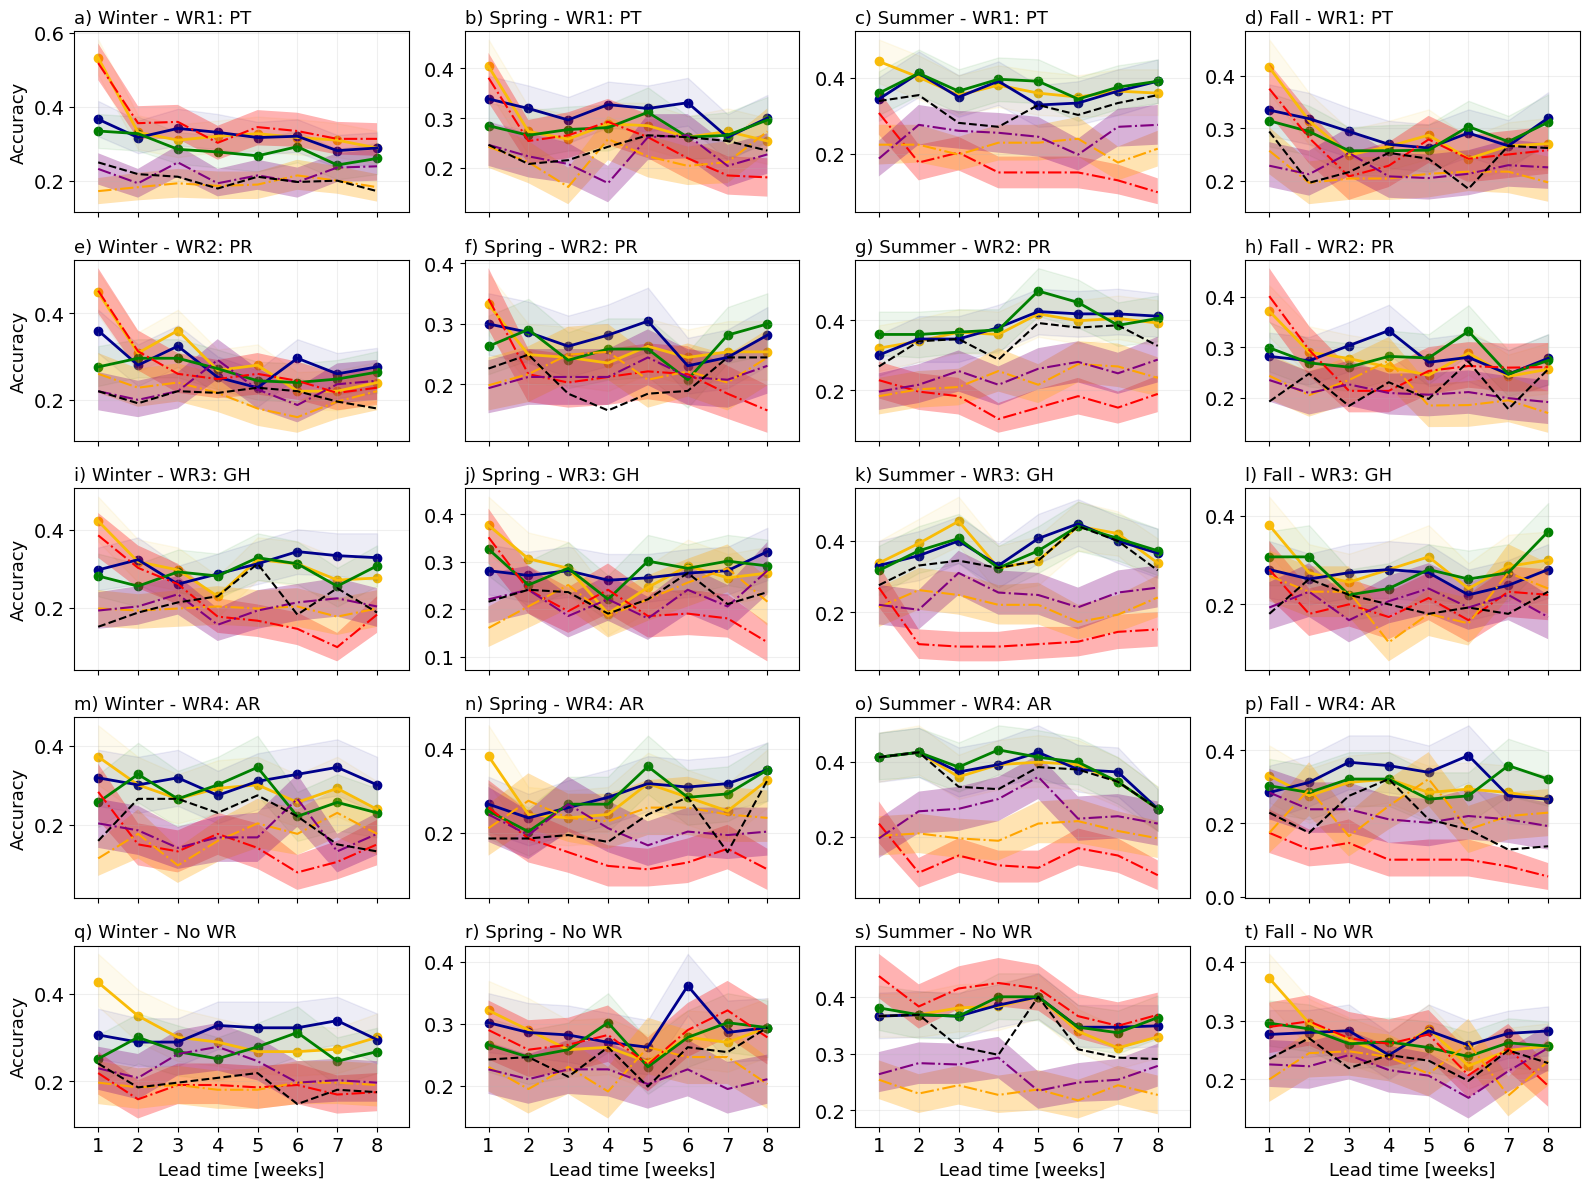

In [27]:
alphabet = list(string.ascii_lowercase)
weeks = np.arange(1, 9)

# Create a figure and a set of subplots
fig, axs = plt.subplots(5, 4, figsize=(16, 12))  # 4x4 grid of subplots
axs_list = axs.flatten().tolist()

counter2 = 0
for weather_regime, weather_regime_name in enumerate(names_wr):
    print(weather_regime_name)
    wr = weather_regime
    for iseason, season in enumerate(indices_seasons.keys()):
        print(season)
        dic_atm = {}
        dic_atm['all_f1s'] = []
        dic_atm['names'] = []
        
        for ivar in indices_vars_atm:
            dic_atm['all_f1s'].append(np.load(f'{path_f1s_starting_wrs_seasonal}f1_{list_vars[ivar]}_wr{weather_regime}_{season}.npy'))
            dic_atm['names'].append(list_vars[ivar])
        dic_atm['all_f1s'].append(np.load(f'{path_f1s_starting_wrs_seasonal}/f1_atm_wr{weather_regime}_{season}.npy'))
        dic_atm['names'].append(f'All atm.')
        
        dic_atm['all_f1s'] = np.array(dic_atm['all_f1s'])
        dic_atm['names'] = np.array(dic_atm['names'])
        dic_atm['best_model'] = dic_atm['names'][dic_atm['all_f1s'][:,:,0].argmax(axis=0)]
        
        dic_ocn = {}
        dic_ocn['all_f1s'] = []
        dic_ocn['names'] = []
        
        for ivar in indices_vars_ocn:
            dic_ocn['all_f1s'].append(np.load(f'{path_f1s_starting_wrs_seasonal}f1_{list_vars[ivar]}_wr{weather_regime}_{season}.npy'))
            dic_ocn['names'].append(list_vars[ivar])
        dic_ocn['all_f1s'].append(np.load(f'{path_f1s_starting_wrs_seasonal}/f1_ocn_wr{weather_regime}_{season}.npy'))
        dic_ocn['names'].append(f'All ocn.')
        
        dic_ocn['all_f1s'] = np.array(dic_ocn['all_f1s'])
        dic_ocn['names'] = np.array(dic_ocn['names'])
        dic_ocn['best_model'] = dic_ocn['names'][dic_ocn['all_f1s'][:,:,0].argmax(axis=0)]
        
        dic_lnd = {}
        dic_lnd['all_f1s'] = []
        dic_lnd['names'] = []
        
        for ivar in indices_vars_lnd:
            dic_lnd['all_f1s'].append(np.load(f'{path_f1s_starting_wrs_seasonal}f1_{list_vars[ivar]}_wr{weather_regime}_{season}.npy'))
            dic_lnd['names'].append(list_vars[ivar])
        dic_lnd['all_f1s'].append(np.load(f'{path_f1s_starting_wrs_seasonal}/f1_lnd_wr{weather_regime}_{season}.npy'))
        dic_lnd['names'].append(f'All lnd.')
        
        dic_lnd['all_f1s'] = np.array(dic_lnd['all_f1s'])
        dic_lnd['names'] = np.array(dic_lnd['names'])
        dic_lnd['best_model'] = dic_lnd['names'][dic_lnd['all_f1s'][:,:,0].argmax(axis=0)]
        
        f1_persistence = np.load(f'{path_f1s_starting_wrs_seasonal}f1_persistence_wr{weather_regime}_{season}.npy')
        f1_climatology = np.load(f'{path_f1s_starting_wrs_seasonal}f1_climatology_wr{weather_regime}_{season}.npy')
        f1_random = np.load(f'{path_f1s_starting_wrs_seasonal}f1_random_wr{weather_regime}_{season}.npy')
        f1_all = np.load(f'{path_f1s_starting_wrs_seasonal}/f1_all_wr{weather_regime}_{season}.npy')
    
        best_f1_atm = np.array([dic_atm['all_f1s'][iwhere, iweek]\
                            for iweek, iwhere in enumerate(dic_atm['all_f1s'][:,:,0].argmax(axis=0))])
        
        best_f1_ocn = np.array([dic_ocn['all_f1s'][iwhere, iweek]\
                            for iweek, iwhere in enumerate(dic_ocn['all_f1s'][:,:,0].argmax(axis=0))])
        
        best_f1_lnd = np.array([dic_lnd['all_f1s'][iwhere, iweek]\
                            for iweek, iwhere in enumerate(dic_lnd['all_f1s'][:,:,0].argmax(axis=0))])

        print(dic_atm['best_model'])
        print(dic_ocn['best_model'])
        print(dic_lnd['best_model'])
        
        axs_list[counter2].plot(weeks,best_f1_atm[:,0],label=f'Best atmosphere model',color='#f9bc08',lw=2)
        axs_list[counter2].scatter(weeks,best_f1_atm[:,0],color='#f9bc08')#, s=diff*100)
        
        axs_list[counter2].plot(weeks,best_f1_ocn[:,0],label=f'Best ocean model',color='darkblue',lw=2)
        axs_list[counter2].scatter(weeks,best_f1_ocn[:,0],color='darkblue')
        
        axs_list[counter2].plot(weeks,best_f1_lnd[:,0],label=f'Best land model',color='green',lw=2)
        axs_list[counter2].scatter(weeks,best_f1_lnd[:,0],color='green')
        
        axs_list[counter2].fill_between(weeks, best_f1_atm[:,1], 
                         best_f1_atm[:,2], color='#f9bc08', alpha=0.07)
        axs_list[counter2].fill_between(weeks, best_f1_ocn[:,1], 
                         best_f1_ocn[:,2], color='darkblue', alpha=0.07)
        axs_list[counter2].fill_between(weeks, best_f1_lnd[:,1], 
                         best_f1_lnd[:,2], color='green', alpha=0.07)
        
        # Plot benchmarks
        axs_list[counter2].plot(weeks, f1_persistence[:,0], color='red', label='Persistence', ls='dashdot')
        axs_list[counter2].fill_between(weeks, f1_persistence[:,1],f1_persistence[:,2], 
                              color='red', ls='dashdot', lw=0.01,alpha=0.3)
        
        
        axs_list[counter2].plot(weeks, f1_random[:,0], color='orange', label='Random', ls='dashdot')
        axs_list[counter2].fill_between(weeks, f1_random[:,1],f1_random[:,2], 
                              color='orange', ls='dashdot', lw=0.01,alpha=0.3)
        
        axs_list[counter2].plot(weeks, f1_climatology[:,0], color='purple', label='Climatology', ls='dashdot')
        axs_list[counter2].fill_between(weeks, f1_climatology[:,1],f1_climatology[:,2], 
                              color='purple', ls='dashdot', lw=0.01,alpha=0.3)
        ## Plot joint model
        axs_list[counter2].plot(weeks, f1_all[:,0], color='k', label='All vars.', ls='dashed')
        
        # constant = -0.12
        # if weather_regime==2:
        #     constant = 0.07
        # if weather_regime==3:
        #     constant = 0.07
        # if weather_regime==4:
        #     constant = -0.06
        # # Plot best model
        # for i, j, d in zip(weeks, best_f1_atm[:,0], dic_atm['best_model'][:]):
        #     axs_list[counter2].text(i - 0.25, 0.20+constant, s=d.replace('_ERA5',''), 
        #                   color = '#f9bc08',fontsize=10)
        # for i, j, d in zip(weeks, best_f1_ocn[:,0], dic_ocn['best_model'][:]):
        #     axs_list[counter2].text(i - 0.25, 0.19+constant, s=d.replace('_SODA','').replace('_OISSTv2','')\
        #                   .replace('_wT',' \nwT'), 
        #                   color = 'darkblue',fontsize=10)
        # for i, j, d in zip(weeks, best_f1_lnd[:,0], dic_lnd['best_model'][:]):
        #     axs_list[counter2].text(i - 0.25,  0.18+constant, s=d.replace('SWVL','SWC').replace('STL','ST')\
        #                   .replace('_ERA5','').replace('_',' ').replace(' wT',' \nwT'), 
        #                   color = 'green',fontsize=10)
        
        axs_list[counter2].set_xlim(0.4, 8.8)
        # axs_list[counter2].set_ylim(0.0, 0.45)
        axs_list[counter2].tick_params(axis='both', which='major', labelsize=14)
        axs_list[counter2].grid(alpha=0.2)
        # axs_list[counter2].set_ylabel('F1 Score',fontsize=14)
        # axs_list[counter2].set_xlabel('Lead time [weeks]',fontsize=14)
        abcd = list(string.ascii_lowercase)
        axs_list[counter2].set_title(f'{abcd[weather_regime]}) {weather_regime_name}', loc='left',fontsize=14)
        # axs_list[counter2].legend(bbox_to_anchor=(1, 1.0), fontsize=9,ncol=3)

        if iseason % 4 == 0:
            axs_list[counter2].set_ylabel("Accuracy", fontsize=13)
            axs_list[counter2].tick_params(axis='both', which='major', labelsize=14)
        # else:
        #     axs_list[counter2].tick_params(labelleft=False)
        if wr == 4:
            axs_list[counter2].set_xlabel("Lead time [weeks]", fontsize=13)
            axs_list[counter2].set_xticks(np.arange(1, 9))
            axs_list[counter2].tick_params(axis='both', which='major', labelsize=14)
        else:
            axs_list[counter2].set_xticks(np.arange(1, 9))
            axs_list[counter2].tick_params(labelbottom=False)
        
        # Calculate the counter based on row and column position
        # counter = iseason + wr * len(seasons)
        
        axs_list[counter2].set_title(f"{alphabet[counter2]}) {season} - {names_wr[wr]}", loc="left", fontsize=13)
        counter2 += 1
plt.tight_layout()
